<a href="https://colab.research.google.com/github/vijayhareesh/llm_podcast_summary/blob/main/Uplimit_Week1_VijayA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is part of the course: [Building AI products with OpenAI](https://corise.com/go/building-ai-products-with-openai-MWKY3) and is created by Sidharth Ramachandran as the project for this course.

# Summarize & highlight podcast episodes for busy listeners

Welcome to the project that is part of the course - **Building AI products with OpenAI**. In this project, you are going to build an LLM app that summarizes a podcast episode, identifies podcast guests, identifies key highlights and more!

# The Problem

I'm a huge fan of podcasts and love the format as a way to gain deep insights into different industries & technologies and learn from the lived experience of people all over the world. But there is limited time and I end up listening to only some of them! I'm subscribed to several interesting podcasts that release 1-2 episodes a week and the problem is that it's hard to identify an episode that would appeal to me. While many episodes provide show notes, additional links and timestamps, I don't find them very helpful in truly understanding the unique aspects and making me want to listen to it! How can I make this discovery process more interesting and efficient?

# Solution

We would like to generate a personalized newsletter every week that summarizes each podcast episode released in that week. It would include information about the guest on the episode, the main topics discussed as well as some highlights. It would work by collecting a list of RSS feeds from the user and on a periodic basis, process the latest episodes and generate the newsletter. This acts as a round-up of the week, provides the user with the right level of detail that allows them to decide which of the episodes are appealing and must be listened to.

# Approach

We will divide the approach to building this product into three parts -

- Part 1: use a Large Language Model (LLM) from OpenAI to build the information extraction functionality paired with a Speech to Text model for transcribing the podcast
- Part 2: use a simple cloud deployment provider to easily convert the information extraction function to run on demand - this would be the app backend
- Part 3: use ChatGPT from OpenAI as your coding assistant to create and deploy a front-end that allows users to experience the end to end functionality

Through this project our aim is to understand how we can approach building and deploying LLM apps that add value to users. We will also provide ideas for interesting extensions and additional functionality at several parts in the project. These are optional but we are excited to see what you might build and showcase in the Demo-Day!

# Part 1 - Podcast Transcription and Information Extraction

## Step 1 - Retrieve the audio file

The first step is to get the RSS feed of the podcast, identify the latest episode and retrieve the audio file (typically in MP3 format). One of my favorite websites to find information about podcasts is [ListenNotes](https://www.listennotes.com/). You can search for any podcast you like and then click on the RSS icon to retrieve the RSS feed.

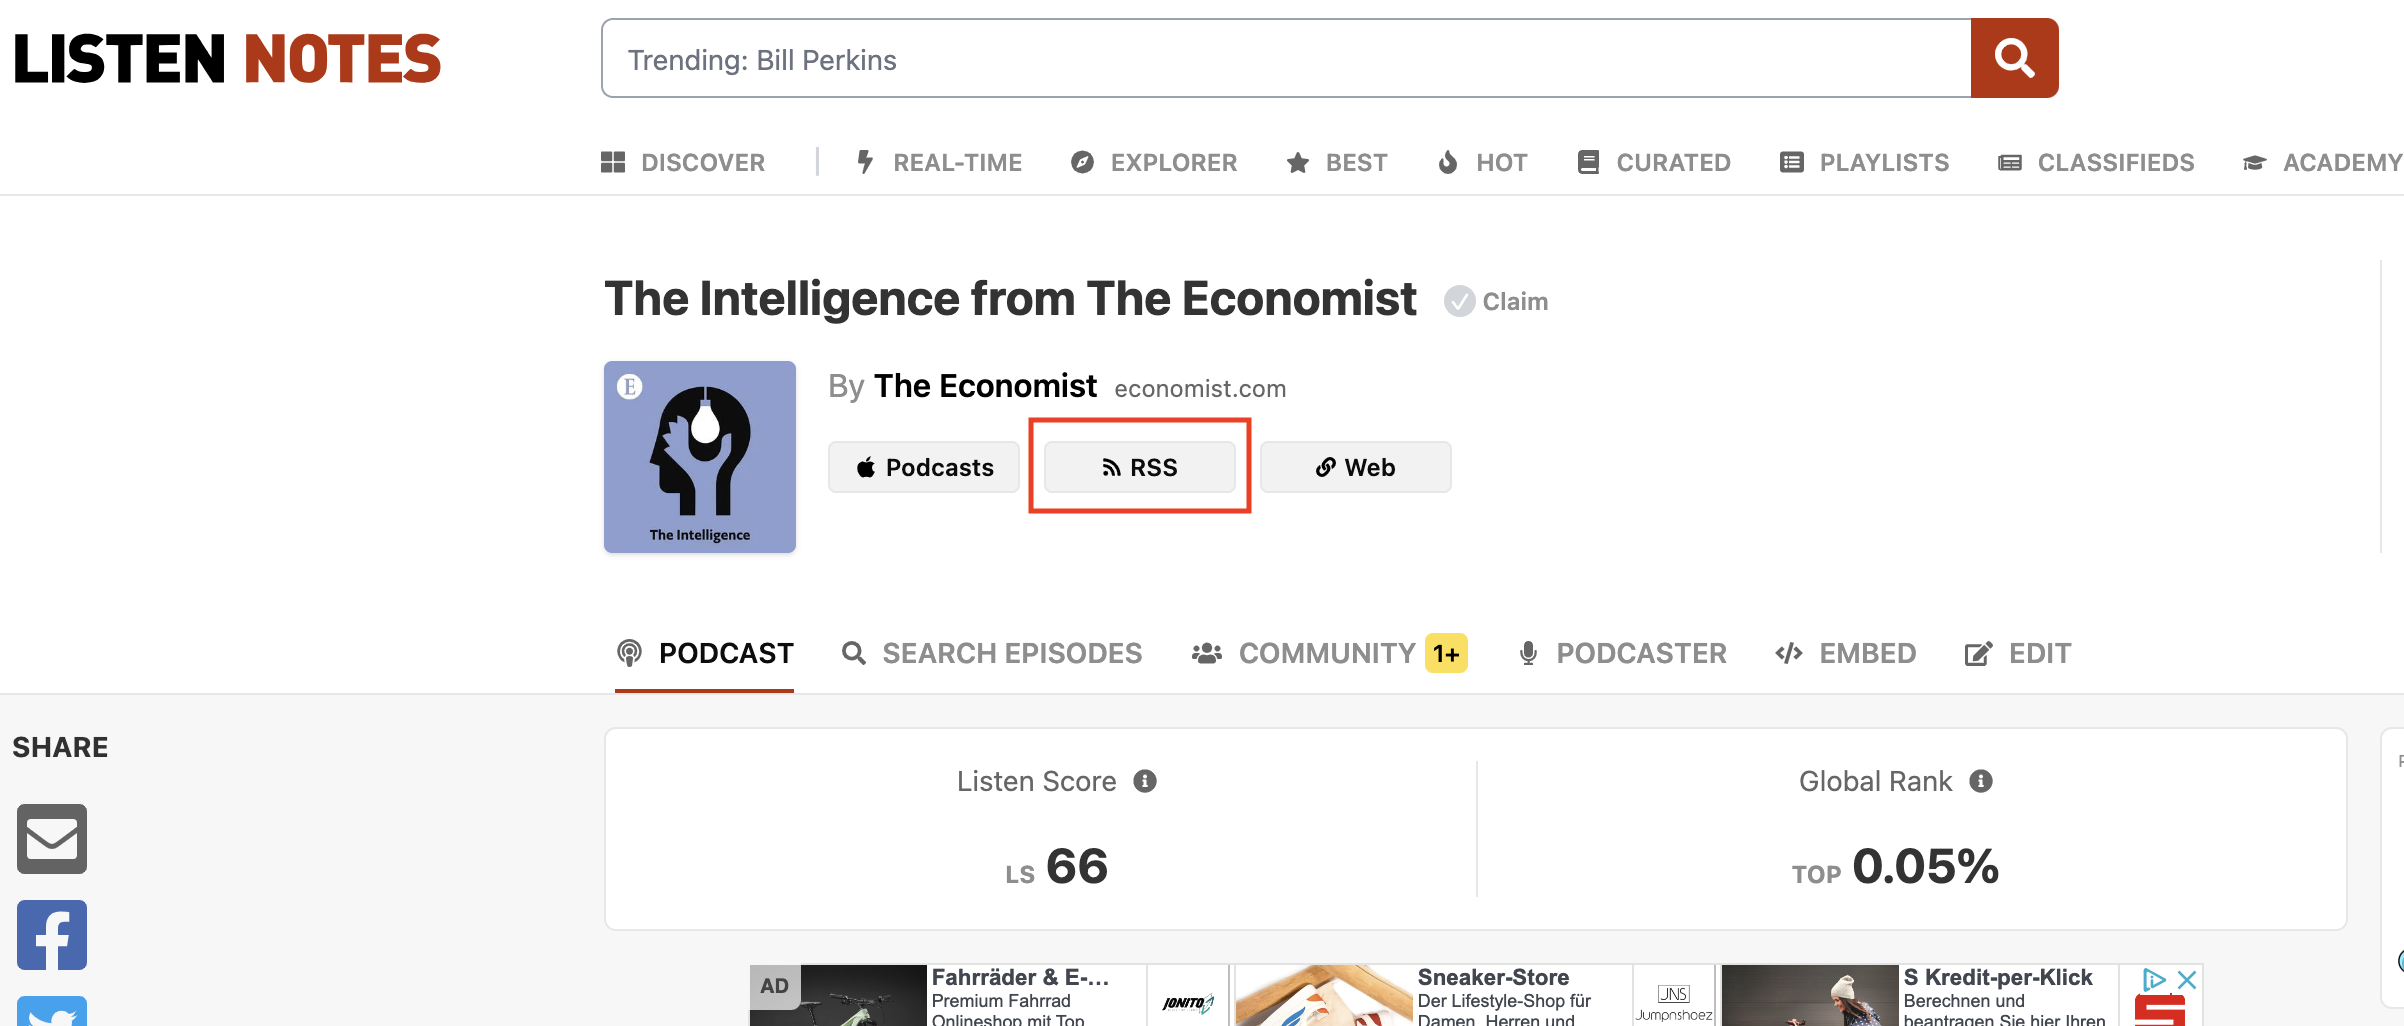

For example, The Economist publishes a daily news roundup podcast called [The Intelligence](https://www.listennotes.com/podcasts/the-intelligence-from-the-economist-the-stZlS3fr8KO/) which is quite concise and informative. Let's use the RSS feed of this podcast.

⚠️⚠️⚠️ ⏭ **IMPORTANT NOTE** ⏮ ⚠️⚠️⚠️

This project has been setup for podcast episodes that have a run-time between 25-30 minutes. The bottleneck is the transcription time using Whisper and as a result how long a GPU will be kept available in the Google Colab environment.

Transcribing longer podcasts is possible and can be achieved by splitting up the podcast into different chunks. For those who are interested please look-up the reference [implementation](https://github.com/modal-labs/modal-examples/blob/main/06_gpu_and_ml/openai_whisper/pod_transcriber/app/main.py) provided by Modal Labs. We will use a basic workflow of Modal in Part-2 of this project, so feel free to revisit this section.

In [ ]:
!pip install feedparser

👨🏻‍💻📝 **Participant Input Required:** Please enter the RSS feed URL of your selected podcast in the below cell.


---



In [ ]:
import feedparser
podcast_feed_url = "YOUR_PODCAST_RSS_FEED_URL"
podcast_feed = feedparser.parse(podcast_feed_url)

In [ ]:
print ("The number of podcast entries is ", len(podcast_feed.entries))

Let's get the URL of the most recent episode from the feed and then download the corresponding MP3 file and save it on Google Colab as `podcast_episode.mp3`

In [ ]:
for item in podcast_feed.entries[0].links:
  if (item['type'] == 'audio/mpeg'):
    episode_url = item.href
!wget -O 'podcast_episode.mp3' {episode_url}

To confirm that the podcast episode has been downloaded, you can use the left-hand navigation pane in Google Colab to navigate to the folder section and check.

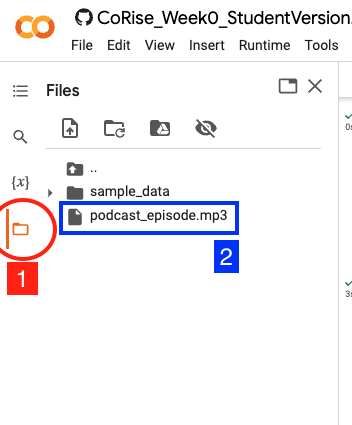

## Step 2 - Transcribe the Audio file

We will use [Whisper](https://github.com/openai/whisper) as our speech to text model. This model has been open-sourced by OpenAI and we can just download it and use it directly. We first install the whisper package and then use the `medium` model to transcribe our downloaded podcast.

Please note that some of the below cells may take upto a minute to run - as it downloads a model of size 1.5 GB and then loads it into GPU memory.

In [ ]:
!pip install git+https://github.com/openai/whisper.git  -q

In [ ]:
%%time

import pathlib
import whisper
# Perform download only once and save to Network storage
model_path = pathlib.Path("/content/podcast/medium.pt")
if model_path.exists():
  print ("Model has been downloaded, no re-download necessary")
else:
  print ("Starting download of Whisper Model")
  whisper._download(whisper._MODELS["medium"], '/content/podcast/', False)

In [ ]:
# Load model from saved location
model = whisper.load_model('medium', device='cuda', download_root='/content/podcast/')

Now we need to pass in the location of our downloaded podcast file to get the transcript.

**NOTE**:
- This step will probably take longer to complete depending on the length of the podcast episode.
- We have created this notebook with the GPU runtime enabled and this will already speed things up. In the free version of Google Colab the notebook will most likely be assigned a T4 GPU which takes roughly a fifth (20%) of the episode runtime for the transcription.
- If you have a paid version of Google Colab, you can choose a different GPU like V100 or A100 to speed things up.

In [ ]:
%%time
result = model.transcribe("/content/podcast_episode.mp3")

In [ ]:
# Check the transcription happened correctly by peeking into the first 1000 characters
podcast_transcript = result['text']
result['text'][:1000]

To avoid being in the situation that the Colab notebook shuts down and you loose the Python variable holding the transcription and to allow for faster testing of subsequent sections, we would recommend you create a local variable that holds your podcast transcript. You can print the contents of `podcast_transcript` from the previous cell and manually assign it to the variable.

This can be very helpful if you are not going through the notebook in one stretch and want to come back to different sections at a later point in time.

In [ ]:
podcast_transcript

👨🏻‍💻📝 **Participant Input Required:** To prevent Colab time-out issues, please copy-paste the generated transcript in the cell below.


---

In [ ]:
podcast_transcript = """
  COPY-PASTE the content of the variable from previous cell to prevent losing the transcript in case of Colab shutdowns
"""

### Extensions

1. Instead of downloading and running the transcription ourselves, you can also use the hosted version of the OpenAI Whisper model (paid). For more details, you can check the [documentation](https://platform.openai.com/docs/models/whisper).
2. The Whisper model does not provide speaker identification but just transcribes what was said. In some situations, it would be good to identify when there are different speakers in the podcast and seperate their dialogues. There are many [libraries](https://github.com/m-bain/whisperX) that work on top of Whisper to enable this.

## Step 3 - Creating a summary of the podcast

As part of the information extraction, we would first like to create a summary of the podcast. We want this to be concise while still conveying the gist of the episode and trying to catch the attention of the user. We will use the OpenAI `gpt-3.5-turbo` model to generate this summary by passing in the generated transcript. We are asking the LLM to go through the entire transcript we provide and summarize it for us.

We need to install the `openai` and `tiktoken` libraries. The openai library is the Python package that allows us to make calls to the API. The tiktoken library allows us to determine the number of tokens in our transcript and that gives us an indication of costs and also whether we will need to change the model that we use to one with a larger context window. While we can use the API and make calls directly, it's much easier to work with the Python library provided by OpenAI called - `openai` 🤭.

In [ ]:
!pip install openai
!pip install tiktoken

If you have already performed these steps as part of the Lecture notebook and have the API key, then you can simply proceed to the next step.

Before using the OpenAI API, you need to get an API token. Please create an account with OpenAI by visiting this [link](https://platform.openai.com/) and creating an account with a method of your choice. This will allow us to access the API. Once created, please naviagate to the `Manage Accounts` section of your profile and look-up the `Usage` tab. By default, most new accounts automatically get $5 of credit to try the API and this should be enough for the purposes of this project.

Please also visit the `API Keys` tab and Create a new secret key and copy this and keep it available. We will use this API key in subsequent steps while making the API calls.

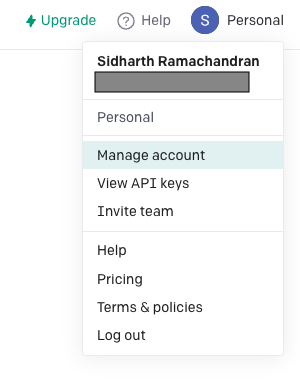

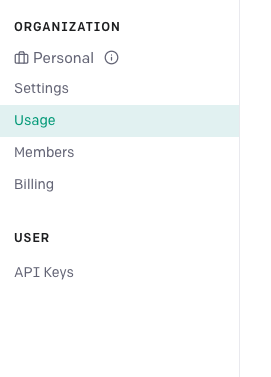

Running the below cell will create an input text box where you need to paste the OpenAI key that you saved previously.

👨🏻‍💻📝 **Participant Input Required:** Please enter your OpenAI key in the text box that shows up when you run the below cell and hit Enter.

---

In [ ]:
import openai
from getpass import getpass

openai.api_key = getpass('Enter the OpenAI API Key in the cell  ')

In [ ]:
# we can confirm that the API key works by listing all the OpenAI models
models = openai.Model.list()
for model in models["data"]:
  print (model["root"])

**Context Window**

It's important to understand the concept of a context window. This is the maximum of the combined text that can be used in one API call to the gpt-3.5-turbo model. It is not only a combination of the input text sent to the model but also takes into consideration the output response as well. Also keep in mind that this is measured in terms of tokens and not words. While we could treat them as analogous, it's technically not the same as one word may actually be broken down into multiple tokens.

It's always best to use the tiktoken package to determine the number of tokens in your text.

In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
print ("Number of tokens in input prompt ", len(enc.encode(podcast_transcript)))

As we can see in the case of the Economist podcast episode, this number of 5031 tokens, which is higher than the 4096 tokens that is accepted by the default [GPT-3.5-turbo model](https://platform.openai.com/docs/models/gpt-3-5). What it means is that we have to make use of the larger, higher capacity model `gpt-3.5-turbo-16k` that has a context size of 16,384 tokens. Let's use this model to generate the summary for our podcast.

👨🏻‍💻📝 **Participant Input Required:** Please enter the prompt that you would like to use to summarize the podcast in the cell below.


---

In [ ]:
instructPrompt = """
YOUR_PROMPT_HERE
"""

request = instructPrompt + podcast_transcript

In [ ]:
chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [ ]:
podcastSummary = chatOutput.choices[0].message.content
podcastSummary

## Step 4 - Using `functions` to extract additional information to provide additional context on the episode

We can provide additional context to the listener about a certain episode if we are able to identify the guest and add a summary of their background and experience.

We can easily find information about the guest using Wikipedia or Google but first we also need to extract the name of the podcast guest. Since we are looking to pass the extracted name of the podcast guest to a subsequent function, we need to ensure that the output we recieve from the API is as structured as possible.

To achieve this, we are going to make use of the recently released `function calling` capability of the OpenAI API that we already introduced in the Lecture session and notebook. Please refer to that notebook for more information.

- The way to achieve this is by defining a function with very clear information on what it expects and in which format. This is specified as a separate input to the chat completion endpoint as you see below.
- Typically in a podcast episode the guest will be introduced in the first half and therefore it's not necessary to use the entire transcript to extract this information.
- We pass in only the first 5000 characters and this will save us token usage as well and therefore we can use the non 16k model.

In [ ]:
request = podcast_transcript[:5000]
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
print ("Number of tokens in input prompt ", len(enc.encode(request)))

👨🏻‍💻📝 **Participant Input Required:** Please enter the description of the function and the variable at the appropriate points below.

---



In [ ]:
completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": request}],
    functions=[
    {
        "name": "get_podcast_guest_information",
        "description": "ADD_THE_FUNCTION_DESCRIPTION_HERE",
        "parameters": {
            "type": "object",
            "properties": {
                "guest_name": {
                    "type": "string",
                    "description": "ADD_THE_VARIABLE_DESCRIPTION_HERE",
                },
                "unit": {"type": "string"},
            },
            "required": ["guest_name"],
        },
    }
    ],
    function_call={"name": "get_podcast_guest_information"}
    )

We can directly see how the output from the API is formatted by checking the response object `completion`

In [ ]:
completion

It looks like the output is formatted with JSON and in a structured way that allows us to use this output directly.

In [ ]:
import json

podcast_guest = ""
response_message = completion["choices"][0]["message"]
if response_message.get("function_call"):
  function_name = response_message["function_call"]["name"]
  function_args = json.loads(response_message["function_call"]["arguments"])
  podcast_guest=function_args.get("guest_name")

print ("Podcast Guest is ", podcast_guest)

In the following step, we install the wikipedia python library and then query Wikipedia to find more information about the podcast guest. We use the extracted information as the input to the call.

In [ ]:
!pip install wikipedia

In [ ]:
import wikipedia
input = wikipedia.page(podcast_guest, auto_suggest=False)

In [ ]:
podcast_guest_info = input.summary
print (podcast_guest_info)

### Extensions

1. Sometimes it's possible that guest extraction may happen partially or not at all. We can still attempt to find more information about the podcast guest by extracting additional information about them like their organization or title.
2. Depending on the podcast and generated transcript, it's also possible that the extraction is incorrect and we need to include error handling for these conditions.
3. It's not necessary that Wikipedia is the best resource for pulling information about the podcast guest. You could also consider adding other APIs (e.g. Google Search) or Databases (e.g. Crunchbase) depending on your use-case.

#### Extension Solution 1

Let's consider the case where podcast guest name may not be enough OR it has not been extracted well or completely. One way to resolve this would be to extract additional information:

- Podcast Guest Organization
- Podcast Guest Title

You can also adjust the prompt to say that we would like to extract the `full name` of the podcast guest. This helps the model understand our intention better. We can also provide more context by including the larger portion (first 10k characters) from the start of the podcast transcript as that's where organization, title and such details might be covered during their introduction.

Let's see what this function looks like.

In [ ]:
request = podcast_transcript[:10000]
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
print ("Number of tokens in input prompt ", len(enc.encode(request)))

In [ ]:
completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": request}],
    functions=[
    {
        "name": "get_podcast_guest_information",
        "description": "Get information on the podcast guest using their full name and the name of the organization they are part of to search for them on Wikipedia or Google",
        "parameters": {
            "type": "object",
            "properties": {
                "guest_name": {
                    "type": "string",
                    "description": "The full name of the guest who is speaking in the podcast",
                },
                "guest_organization": {
                    "type": "string",
                    "description": "The full name of the organization that the podcast guest belongs to or runs",
                },
                "guest_title": {
                    "type": "string",
                    "description": "The title, designation or role of the podcast guest in their organization",
                },
            },
            "required": ["guest_name"],
        },
    }
],
function_call={"name": "get_podcast_guest_information"}
)

In [ ]:
import json

podcast_guest = ""
podcast_guest_org = ""
podcast_guest_title = ""
response_message = completion["choices"][0]["message"]
if response_message.get("function_call"):
  function_name = response_message["function_call"]["name"]
  function_args = json.loads(response_message["function_call"]["arguments"])
  podcast_guest=function_args.get("guest_name")
  podcast_guest_org=function_args.get("guest_organization")
  podcast_guest_title=function_args.get("guest_title")

In [ ]:
print (podcast_guest)
print (podcast_guest_org)
print (podcast_guest_title)

In [ ]:
if podcast_guest_org is None:
  podcast_guest_org = ""
if podcast_guest_title is None:
  podcast_guest_title = ""

In [ ]:
input = wikipedia.page(podcast_guest + " " + podcast_guest_org + " " + podcast_guest_title, auto_suggest=True)

In [ ]:
input.summary

## Step 5: Extract the highlights of the podcast

We've provided our reader with a summary of the podcast and more information about the guest on this episode. What if we could also give them a peak into the conversation?

In this step, we want to extract some key moments in the podcast. These are typically interesting insights from the guest or critical questions that the host might have put forward. It could also be a discussion on a hot topic or controversial opinion.  

👨🏻‍💻📝 **Participant Input Required:** Please enter the prompt that you would use to extract the highlights of the podcast in the cell below.

---

In [ ]:
instructPrompt = """
YOUR_PROMPT_HERE
"""

request = instructPrompt + podcast_transcript

In [ ]:
chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [ ]:
chatOutput.choices[0].message.content

In [ ]:
podcastHighlights = chatOutput.choices[0].message.content

### Extensions

1. There are additional pieces of information that you might choose to extract like
    - the key topics that are being discussed in the episode
    - extract the timestamp along with the highlights so that a user could navigate directly to the location in the podcast where that discussion happens
    - build chapters of the podcast and identify their title


In the previous section we saw that we are able to use the OpenAI API to extract the required information rather easily, the output is delivered in a structured way allowing us to call downstream APIs and much more. This shows us that we could possibly build a product in this direction.

# Part 2 - On-demand information extraction

As we are at a very early stage of prototyping we want to build quickly, be frugal with costs and seek to get feedback as fast as possible. In the following two parts, we will see approaches by which we can build our back-end and front-end services to achieve this.

In this part we want to build our back-end service. We will package the information extraction steps we built previously into an on-demand cloud function. The goal is to have this as our backend service that can process a RSS feed provided by the user, perform the necessary steps and return the final output with all the extracted information.


First, let's encapsulate the podcast retrieval and transcription steps (Steps 1 and 2 of the previous section) into a function and run it locally. Once this is done we will make the necessary changes to convert this to a cloud function.

In [ ]:
!pip install feedparser
!pip install git+https://github.com/openai/whisper.git  -q
!pip install requests

In [ ]:
def get_transcribe_podcast(rss_url, local_path):
  print ("Starting Podcast Transcription Function")
  print ("Feed URL: ", rss_url)
  print ("Local Path:", local_path)

  # Read from the RSS Feed URL
  import feedparser
  intelligence_feed = feedparser.parse(rss_url)
  for item in intelligence_feed.entries[0].links:
    if (item['type'] == 'audio/mpeg'):
      episode_url = item.href
  episode_name = "podcast_episode.mp3"
  print ("RSS URL read and episode URL: ", episode_url)

  # Download the podcast episode by parsing the RSS feed
  from pathlib import Path
  p = Path(local_path)
  p.mkdir(exist_ok=True)

  print ("Downloading the podcast episode")
  import requests
  with requests.get(episode_url, stream=True) as r:
    r.raise_for_status()
    episode_path = p.joinpath(episode_name)
    with open(episode_path, 'wb') as f:
      for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

  print ("Podcast Episode downloaded")

  # Load the Whisper model
  import os
  import whisper
  print ("Download and Load the Whisper model")
  model = whisper.load_model("medium")
  print (model.device)

  # Perform the transcription
  print ("Starting podcast transcription")
  result = model.transcribe(local_path + episode_name)

  # Return the transcribed text
  print ("Podcast transcription completed, returning results...")
  return result

In [ ]:
output = get_transcribe_podcast("https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49", "/content/podcast/")

Let's check the transcription to make sure that our function worked.

In [ ]:
output['text'][:1000]

## Step 1 - Create a cloud transcription function

We will now proceed to make changes to the function that will allow us to run it in the cloud. In order to achieve this we will make use of [Modal Labs](https://modal.com/). This is a service that allows you to convert any Python function to run on-demand in the cloud. The service allows you to run the same Python function which is running locally in the cloud with almost zero effort. Additionally, it supports the use of GPUs which is important in our case given the transcription step. And finally, you only pay for the compute when your function is actually running in the cloud. So if our product does not get many users, we don't pay any ongoing infrastructure costs!

Of course, this is not the only way to run our function in the cloud. A more traditional approach would be to encapsulate your code in a Docker container and use cloud providers like Azure, GCP, AWS etc. to run it. I chose to showcase this method as I found it easy and approachable for anyone withouth having in-depth knowledge about containers, kubernetes, cloud infrastructure etc.

Please follow the steps below:

1. Please visit the specific invite for [Modal Labs](https://modal.com/?utm_source=corise) that's exclusively for this course. Please sign-up to create an account. Right now the service supports acccess only via a Github account.

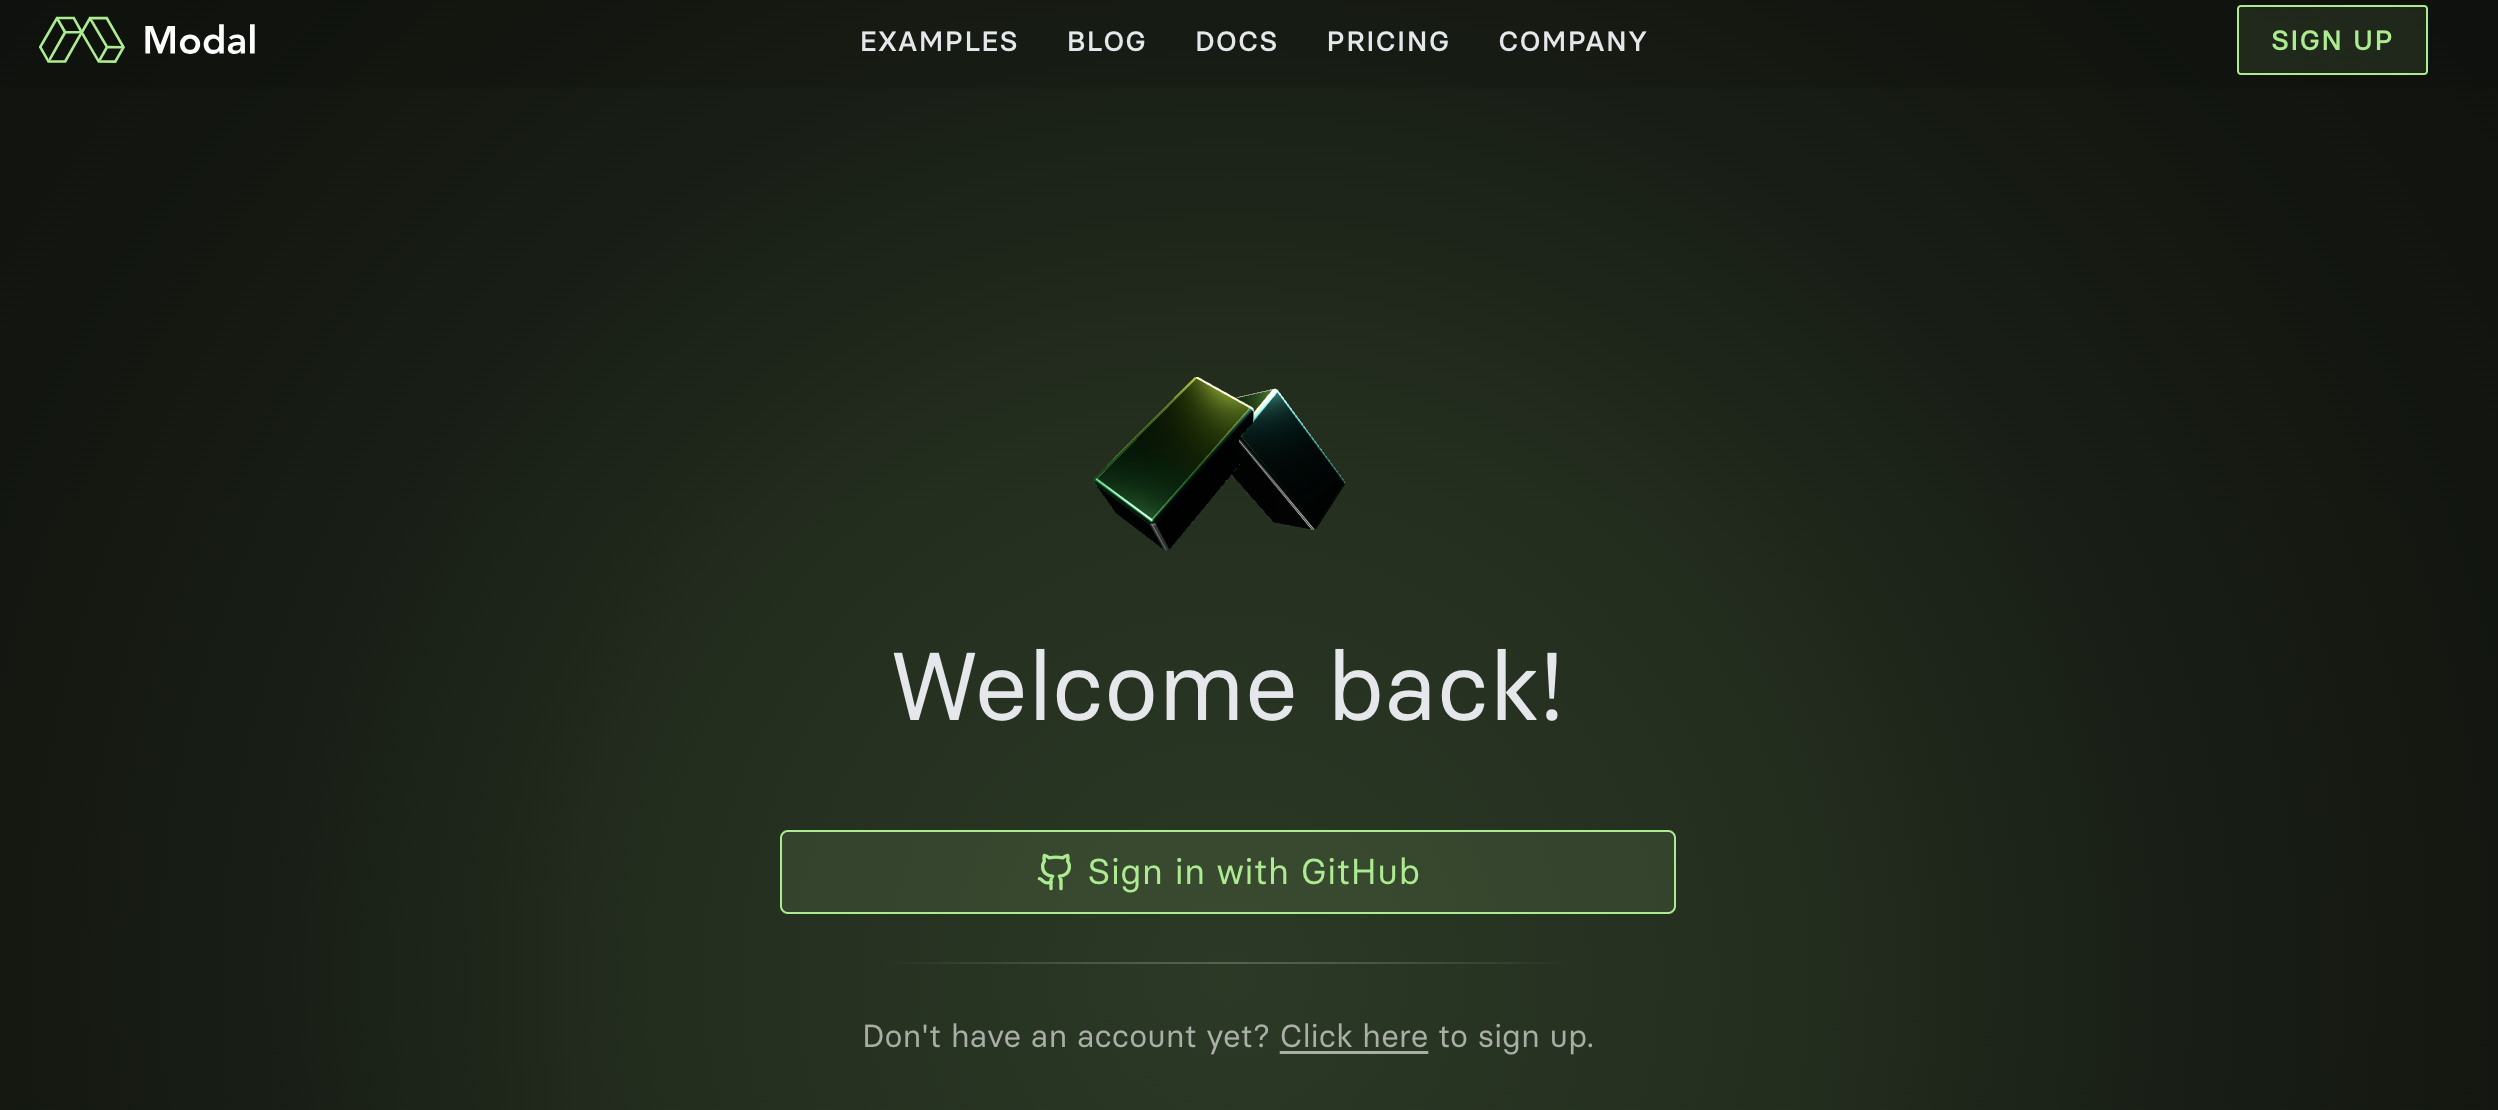

2. The next step is to install the `modal` package using the simple command - `pip install modal`

In [ ]:
!pip install modal

3. Once you have signed up, you will see some instructions on the website but please execute the following additional step. This is a necessary step to grant participants of this course access to Modal labs.

In [ ]:
!modal token new --source corise > authenticationURL.txt

When you run the command, it creates a file in your Colab environment which contains the URL. You can open it by navigating to the folder icon on the left pane of Google Colab and double clicking the file authenticationURL.txt

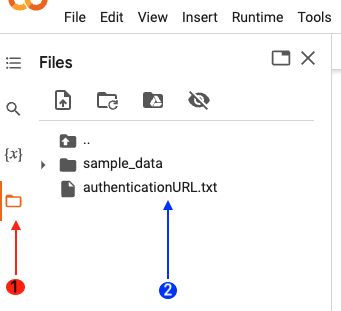

When you double-click the file, you should see it open on the right-side of your Colab notebook and you can follow the link by doing a Ctrl (or Command for Mac) click. This will activate your account with Modal!

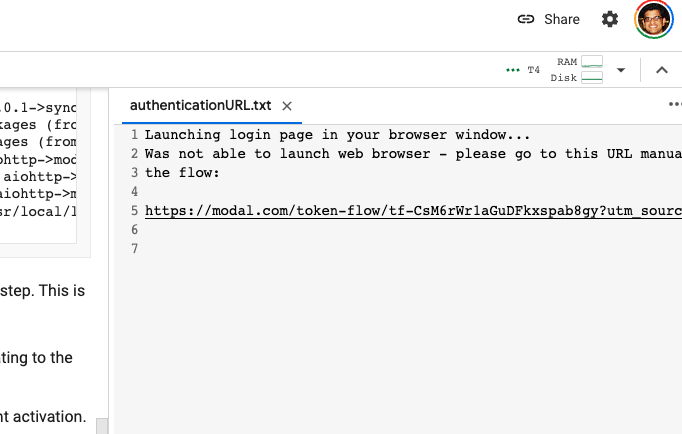

4. Once you have completed sign-in, please navigate to the `Settings` tab and then `API Tokens`. Please click on `Create Token` and then you should see a window pop-up with a command that you can copy. The command will have a format as follows -

`modal token set --token-id TOKEN_ID --token-secret TOKEN_SECRET`

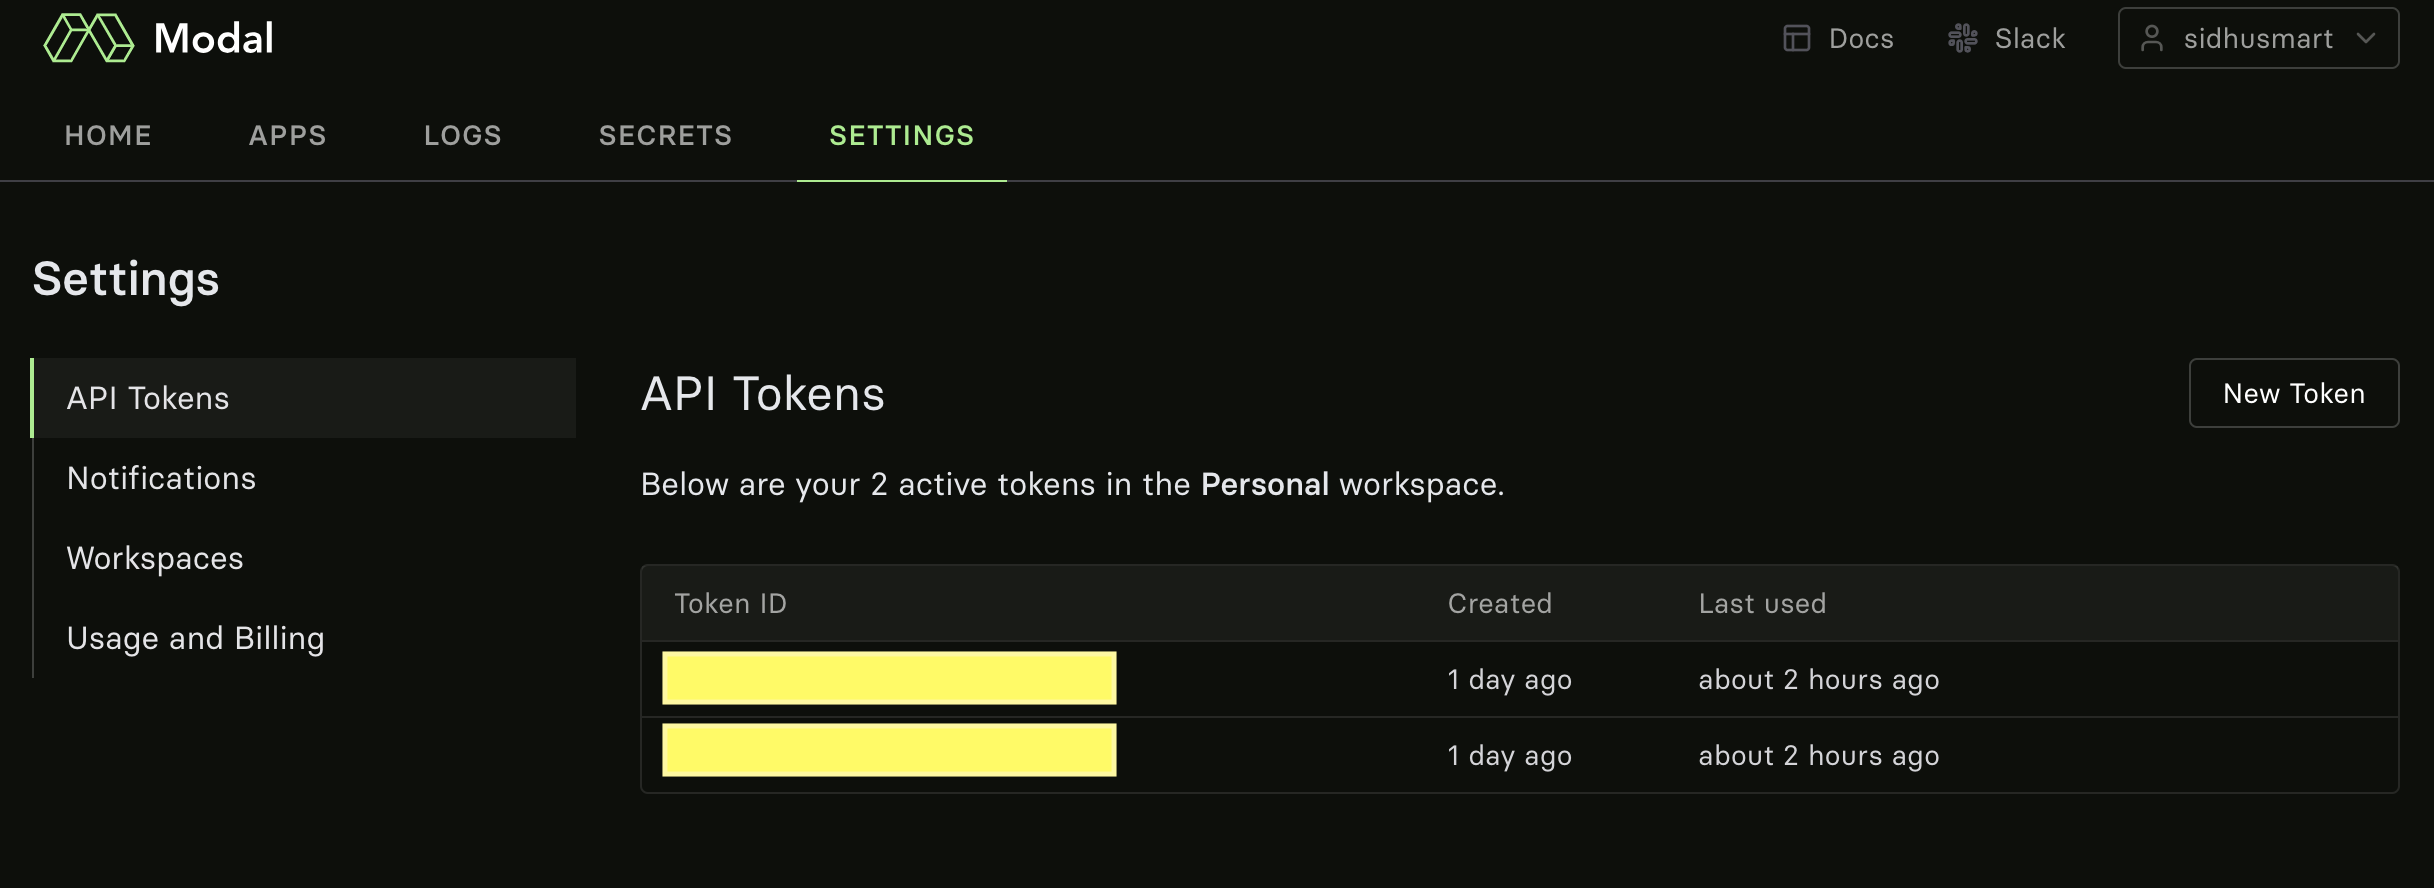

👨🏻‍💻📝 **Participant Input Required:** Due to security reasons, you will see this command only once. Please copy it somewhere safe and you will need to paste the values in the text box that pops up when running the second cell below.


---

In [ ]:
import getpass
import subprocess

def set_modal_token():
  token_id = getpass.getpass('Please enter your Modal token ID in the cell: ')
  token_secret = getpass.getpass('Please enter your Modal token secret in the cell:  ')

  # Using subprocess to execute the command
  subprocess.run(f"!modal token set --token-id (token_id) --token-secret (token_secret)", shell=True)

In [ ]:
set_modal_token()

We have completed the setup of the modal library. We will proceed to make changes to our existing transcription function to adapt it to run in the cloud using modal.

Right now the `modal` library is not setup to run perfectly using an interactive programming environment like Google Colab. This also makes sense given that we plan to use this function for our product and don't want to
 be trigering this from a cell! Therefore, we will create a python file with the function which we will run through a command line.

We add the `%%writefile` line before the function definition and specify the filename where we want to save the Python script.

In [ ]:
%%writefile /content/podcast/podcast_backend.py
import modal

def download_whisper():
  # Load the Whisper model
  import os
  import whisper
  print ("Download the Whisper model")

  # Perform download only once and save to Container storage
  whisper._download(whisper._MODELS["medium"], '/content/podcast/', False)


stub = modal.Stub("corise-podcast-project")
corise_image = modal.Image.debian_slim().pip_install("feedparser",
                                                     "https://github.com/openai/whisper/archive/9f70a352f9f8630ab3aa0d06af5cb9532bd8c21d.tar.gz",
                                                     "requests",
                                                     "ffmpeg").apt_install("ffmpeg").run_function(download_whisper)

@stub.function(image=corise_image, gpu="any")
def get_transcribe_podcast(rss_url, local_path):
  print ("Starting Podcast Transcription Function")
  print ("Feed URL: ", rss_url)
  print ("Local Path:", local_path)

  # Read from the RSS Feed URL
  import feedparser
  intelligence_feed = feedparser.parse(rss_url)
  for item in intelligence_feed.entries[0].links:
    if (item['type'] == 'audio/mpeg'):
      episode_url = item.href
  episode_name = "podcast_episode.mp3"
  print ("RSS URL read and episode URL: ", episode_url)

  # Download the podcast episode by parsing the RSS feed
  from pathlib import Path
  p = Path(local_path)
  p.mkdir(exist_ok=True)

  print ("Downloading the podcast episode")
  import requests
  with requests.get(episode_url, stream=True) as r:
    r.raise_for_status()
    episode_path = p.joinpath(episode_name)
    with open(episode_path, 'wb') as f:
      for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

  print ("Podcast Episode downloaded")

  # Load the Whisper model
  import os
  import whisper

  # Load model from saved location
  print ("Load the Whisper model")
  model = whisper.load_model('medium', device='cuda', download_root='/content/podcast/')

  # Perform the transcription
  print ("Starting podcast transcription")
  result = model.transcribe(local_path + episode_name)

  # Return the transcribed text
  print ("Podcast transcription completed, returning results...")
  return result

@stub.local_entrypoint()
def main(url, path):
  output = get_transcribe_podcast.call(url, path)
  print (output['text'])

We invoke the function from the command line and this will start the remote execution in the cloud environment. Note that we have requested for a GPU since it speeds up the transcription.

In [ ]:
!modal run /content/podcast/podcast_backend.py --url https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49 --path /content/podcast/

Once you call the function, it first sets up the container by installing all the necessary packages. This can take a bit longer but only happens once if you don't make any further changes to your dependencies. After the container is setup, it is spawned and the function is executed. You can track the progress and view the logs of your cloud function by visiting the `Apps` tab on the Modal website.

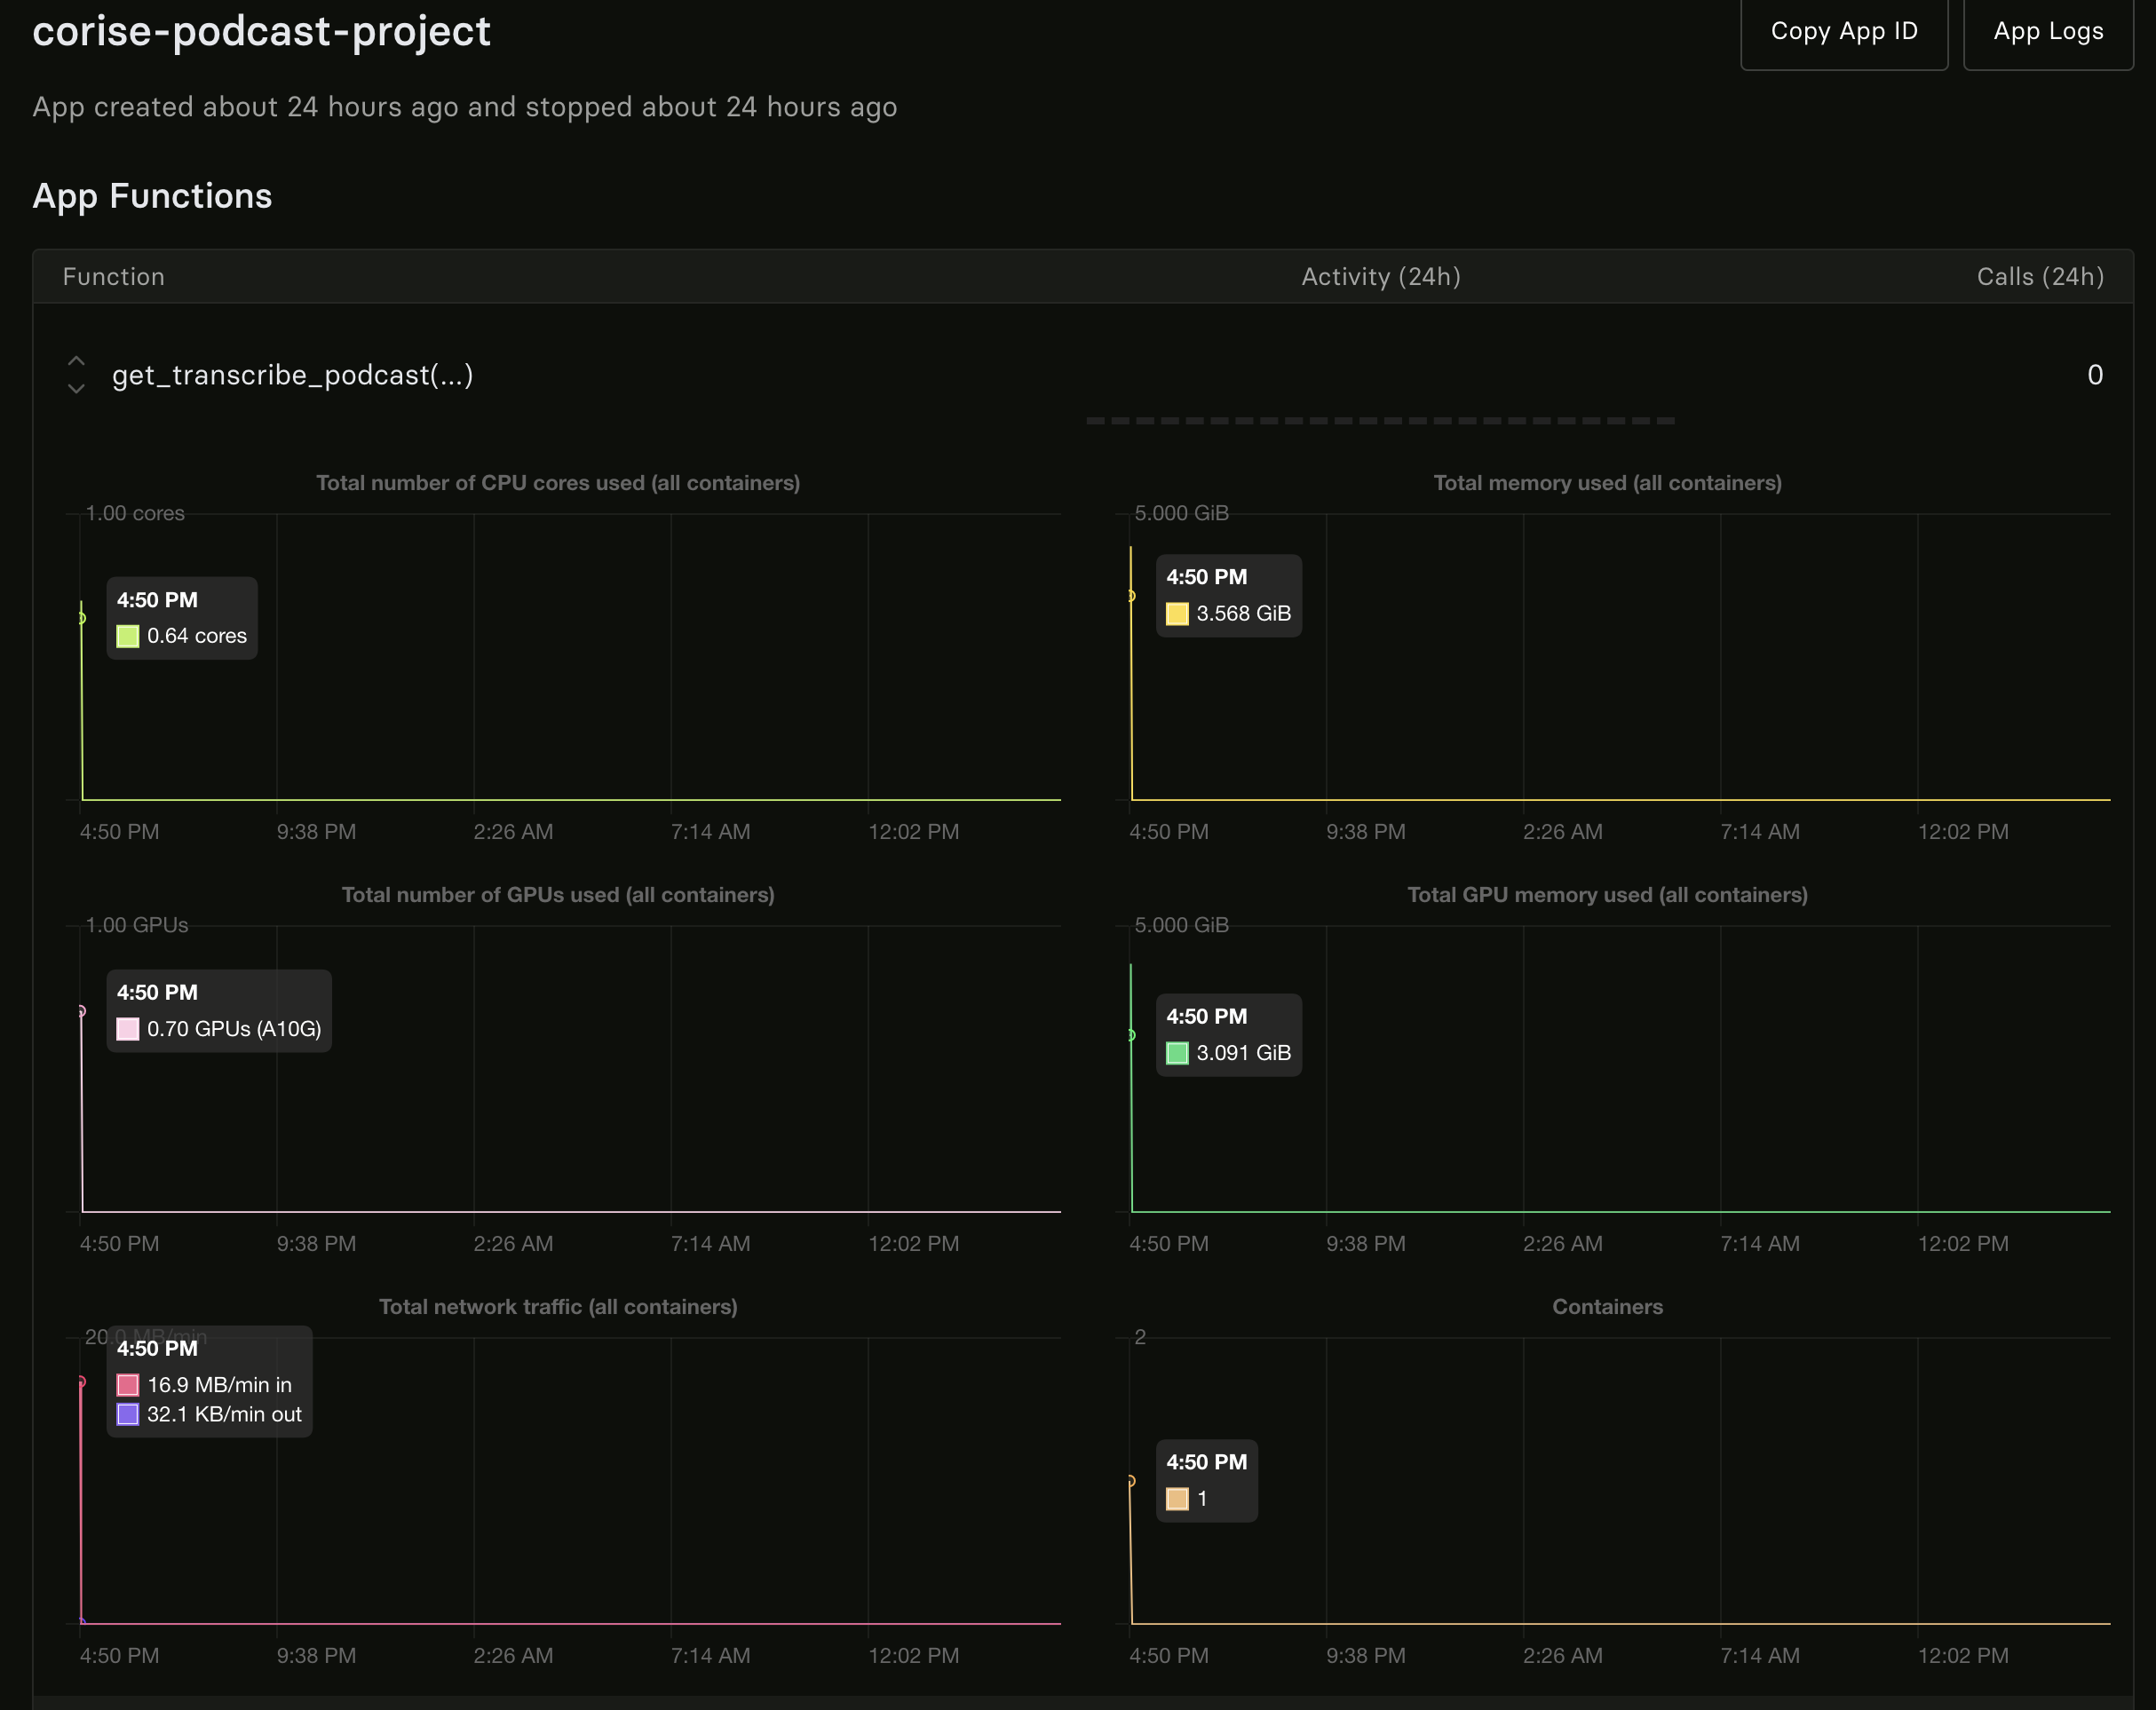

You can see that the run of the app is completed and prints the transcription in the logs. This is not ideal but we anyways will do further extraction steps and include the functions for it. But this entire process ran for roughly 3 minutes on the cloud with a GPU and cost us 7 cents to run.

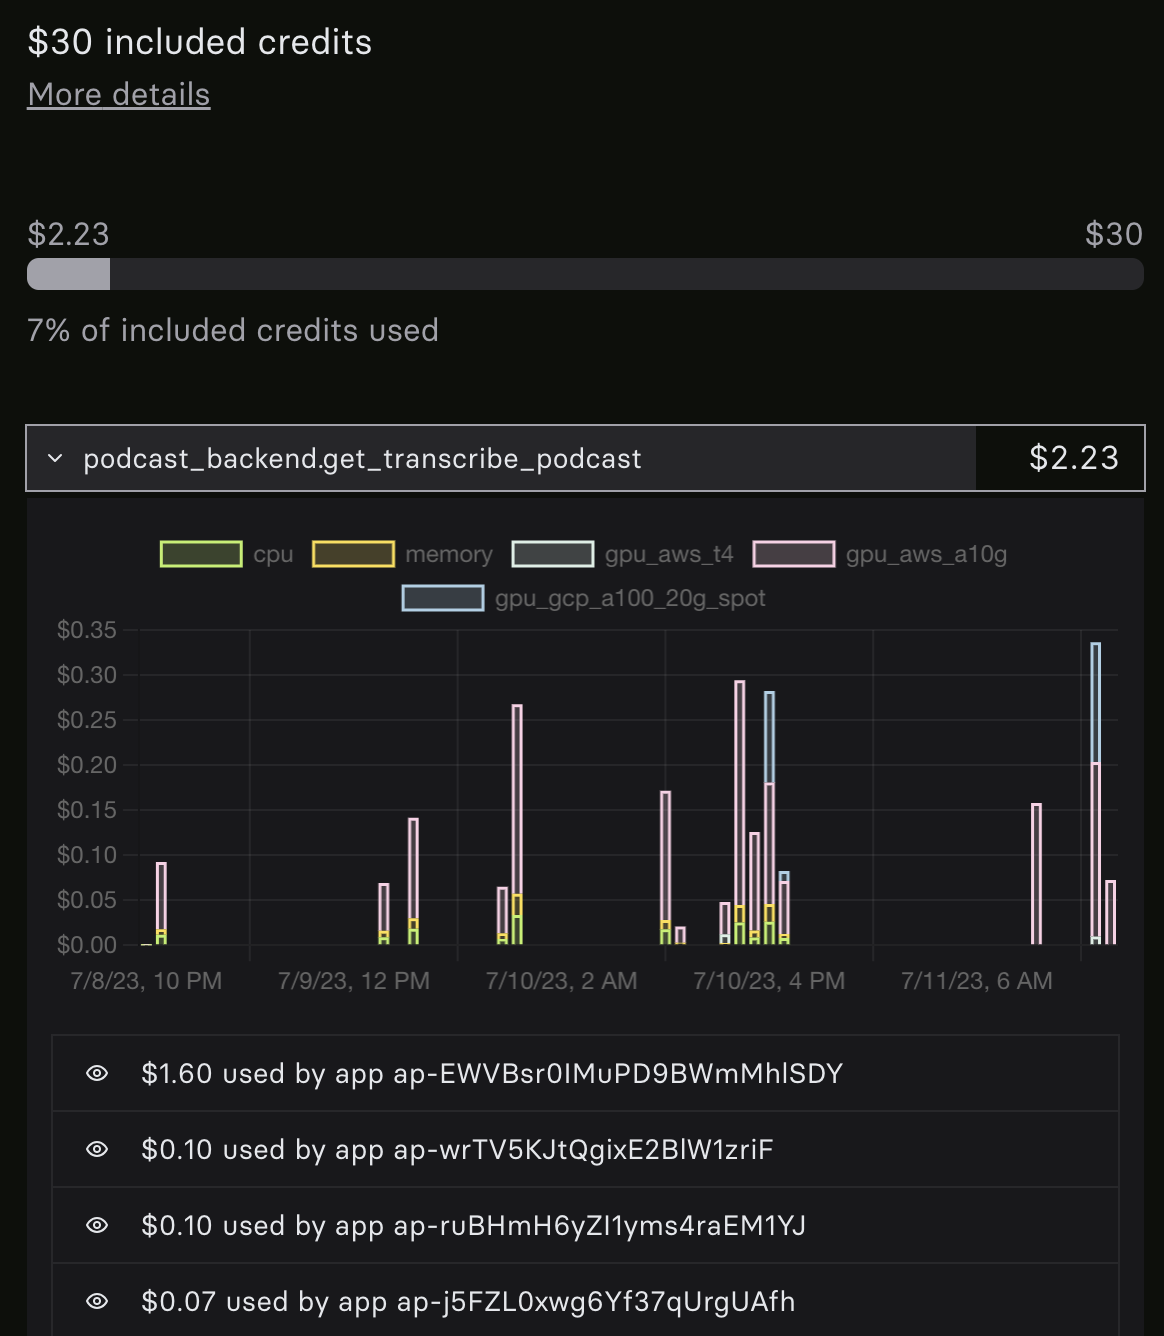

## Step 2 - Create a cloud information extraction function

In the previous step we encapsulated only the transcription function and in this step we want to create functions for all the information extraction functions and deploy our end to end backend pipeline.

In [ ]:
%%writefile /content/podcast/podcast_backend.py
import modal

def download_whisper():
  # Load the Whisper model
  import os
  import whisper
  print ("Download the Whisper model")

  # Perform download only once and save to Container storage
  whisper._download(whisper._MODELS["medium"], '/content/podcast/', False)


stub = modal.Stub("corise-podcast-project")
corise_image = modal.Image.debian_slim().pip_install("feedparser",
                                                     "https://github.com/openai/whisper/archive/9f70a352f9f8630ab3aa0d06af5cb9532bd8c21d.tar.gz",
                                                     "requests",
                                                     "ffmpeg",
                                                     "openai",
                                                     "tiktoken",
                                                     "wikipedia",
                                                     "ffmpeg-python").apt_install("ffmpeg").run_function(download_whisper)

@stub.function(image=corise_image, gpu="any", timeout=600)
def get_transcribe_podcast(rss_url, local_path):
  print ("Starting Podcast Transcription Function")
  print ("Feed URL: ", rss_url)
  print ("Local Path:", local_path)

  # Read from the RSS Feed URL
  import feedparser
  intelligence_feed = feedparser.parse(rss_url)
  podcast_title = intelligence_feed['feed']['title']
  episode_title = intelligence_feed.entries[0]['title']
  episode_image = intelligence_feed['feed']['image'].href
  for item in intelligence_feed.entries[0].links:
    if (item['type'] == 'audio/mpeg'):
      episode_url = item.href
  episode_name = "podcast_episode.mp3"
  print ("RSS URL read and episode URL: ", episode_url)

  # Download the podcast episode by parsing the RSS feed
  from pathlib import Path
  p = Path(local_path)
  p.mkdir(exist_ok=True)

  print ("Downloading the podcast episode")
  import requests
  with requests.get(episode_url, stream=True) as r:
    r.raise_for_status()
    episode_path = p.joinpath(episode_name)
    with open(episode_path, 'wb') as f:
      for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

  print ("Podcast Episode downloaded")

  # Load the Whisper model
  import os
  import whisper

  # Load model from saved location
  print ("Load the Whisper model")
  model = whisper.load_model('medium', device='cuda', download_root='/content/podcast/')

  # Perform the transcription
  print ("Starting podcast transcription")
  result = model.transcribe(local_path + episode_name)

  # Return the transcribed text
  print ("Podcast transcription completed, returning results...")
  output = {}
  output['podcast_title'] = podcast_title
  output['episode_title'] = episode_title
  output['episode_image'] = episode_image
  output['episode_transcript'] = result['text']
  return output

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"))
def get_podcast_summary(podcast_transcript):
  import openai
  ## ADD YOUR LOGIC HERE TO RETURN THE SUMMARY OF THE PODCAST USING OPENAI
  return podcastSummary

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"))
def get_podcast_guest(podcast_transcript):
  import openai
  import wikipedia
  import json
  ## ADD YOUR LOGIC HERE TO RETURN THE PODCAST GUEST INFORMATION
  return podcastGuest

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"))
def get_podcast_highlights(podcast_transcript):
  import openai
  ### ADD YOUR LOGIC HERE TO RETURN THE HIGHLIGHTS OF THE PODCAST
  return podcastHighlights

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"), timeout=1200)
def process_podcast(url, path):
  output = {}
  podcast_details = get_transcribe_podcast.call(url, path)
  podcast_summary = get_podcast_summary.call(podcast_details['episode_transcript'])
  podcast_guest = get_podcast_guest.call(podcast_details['episode_transcript'])
  podcast_highlights = get_podcast_highlights.call(podcast_details['episode_transcript'])
  output['podcast_details'] = podcast_details
  output['podcast_summary'] = podcast_summary
  output['podcast_guest'] = podcast_guest
  output['podcast_highlights'] = podcast_highlights
  return output

@stub.local_entrypoint()
def test_method(url, path):
  output = {}
  podcast_details = get_transcribe_podcast.call(url, path)
  print ("Podcast Summary: ", get_podcast_summary.call(podcast_details['episode_transcript']))
  print ("Podcast Guest Information: ", get_podcast_guest.call(podcast_details['episode_transcript']))
  print ("Podcast Highlights: ", get_podcast_highlights.call(podcast_details['episode_transcript']))

You will notice that we added an additional parameter called `secret` to the information extraction functions. This is necessary because we are going to use OpenAI APIs and for that we need the token. Of course we don't want to pass it in plain text and Modal provides a way to add this. On the Modal portal please go to the `Settings` tab and then click on `Create New Secret`. You will be shown with multiple options and you can select OpenAI and paste the token value. You can also choose the name of the secret (`my-openai-secret`) which should match with what we use in the function definition.

You can create a new token for this on the OpenAI portal and also name it appropriately there.

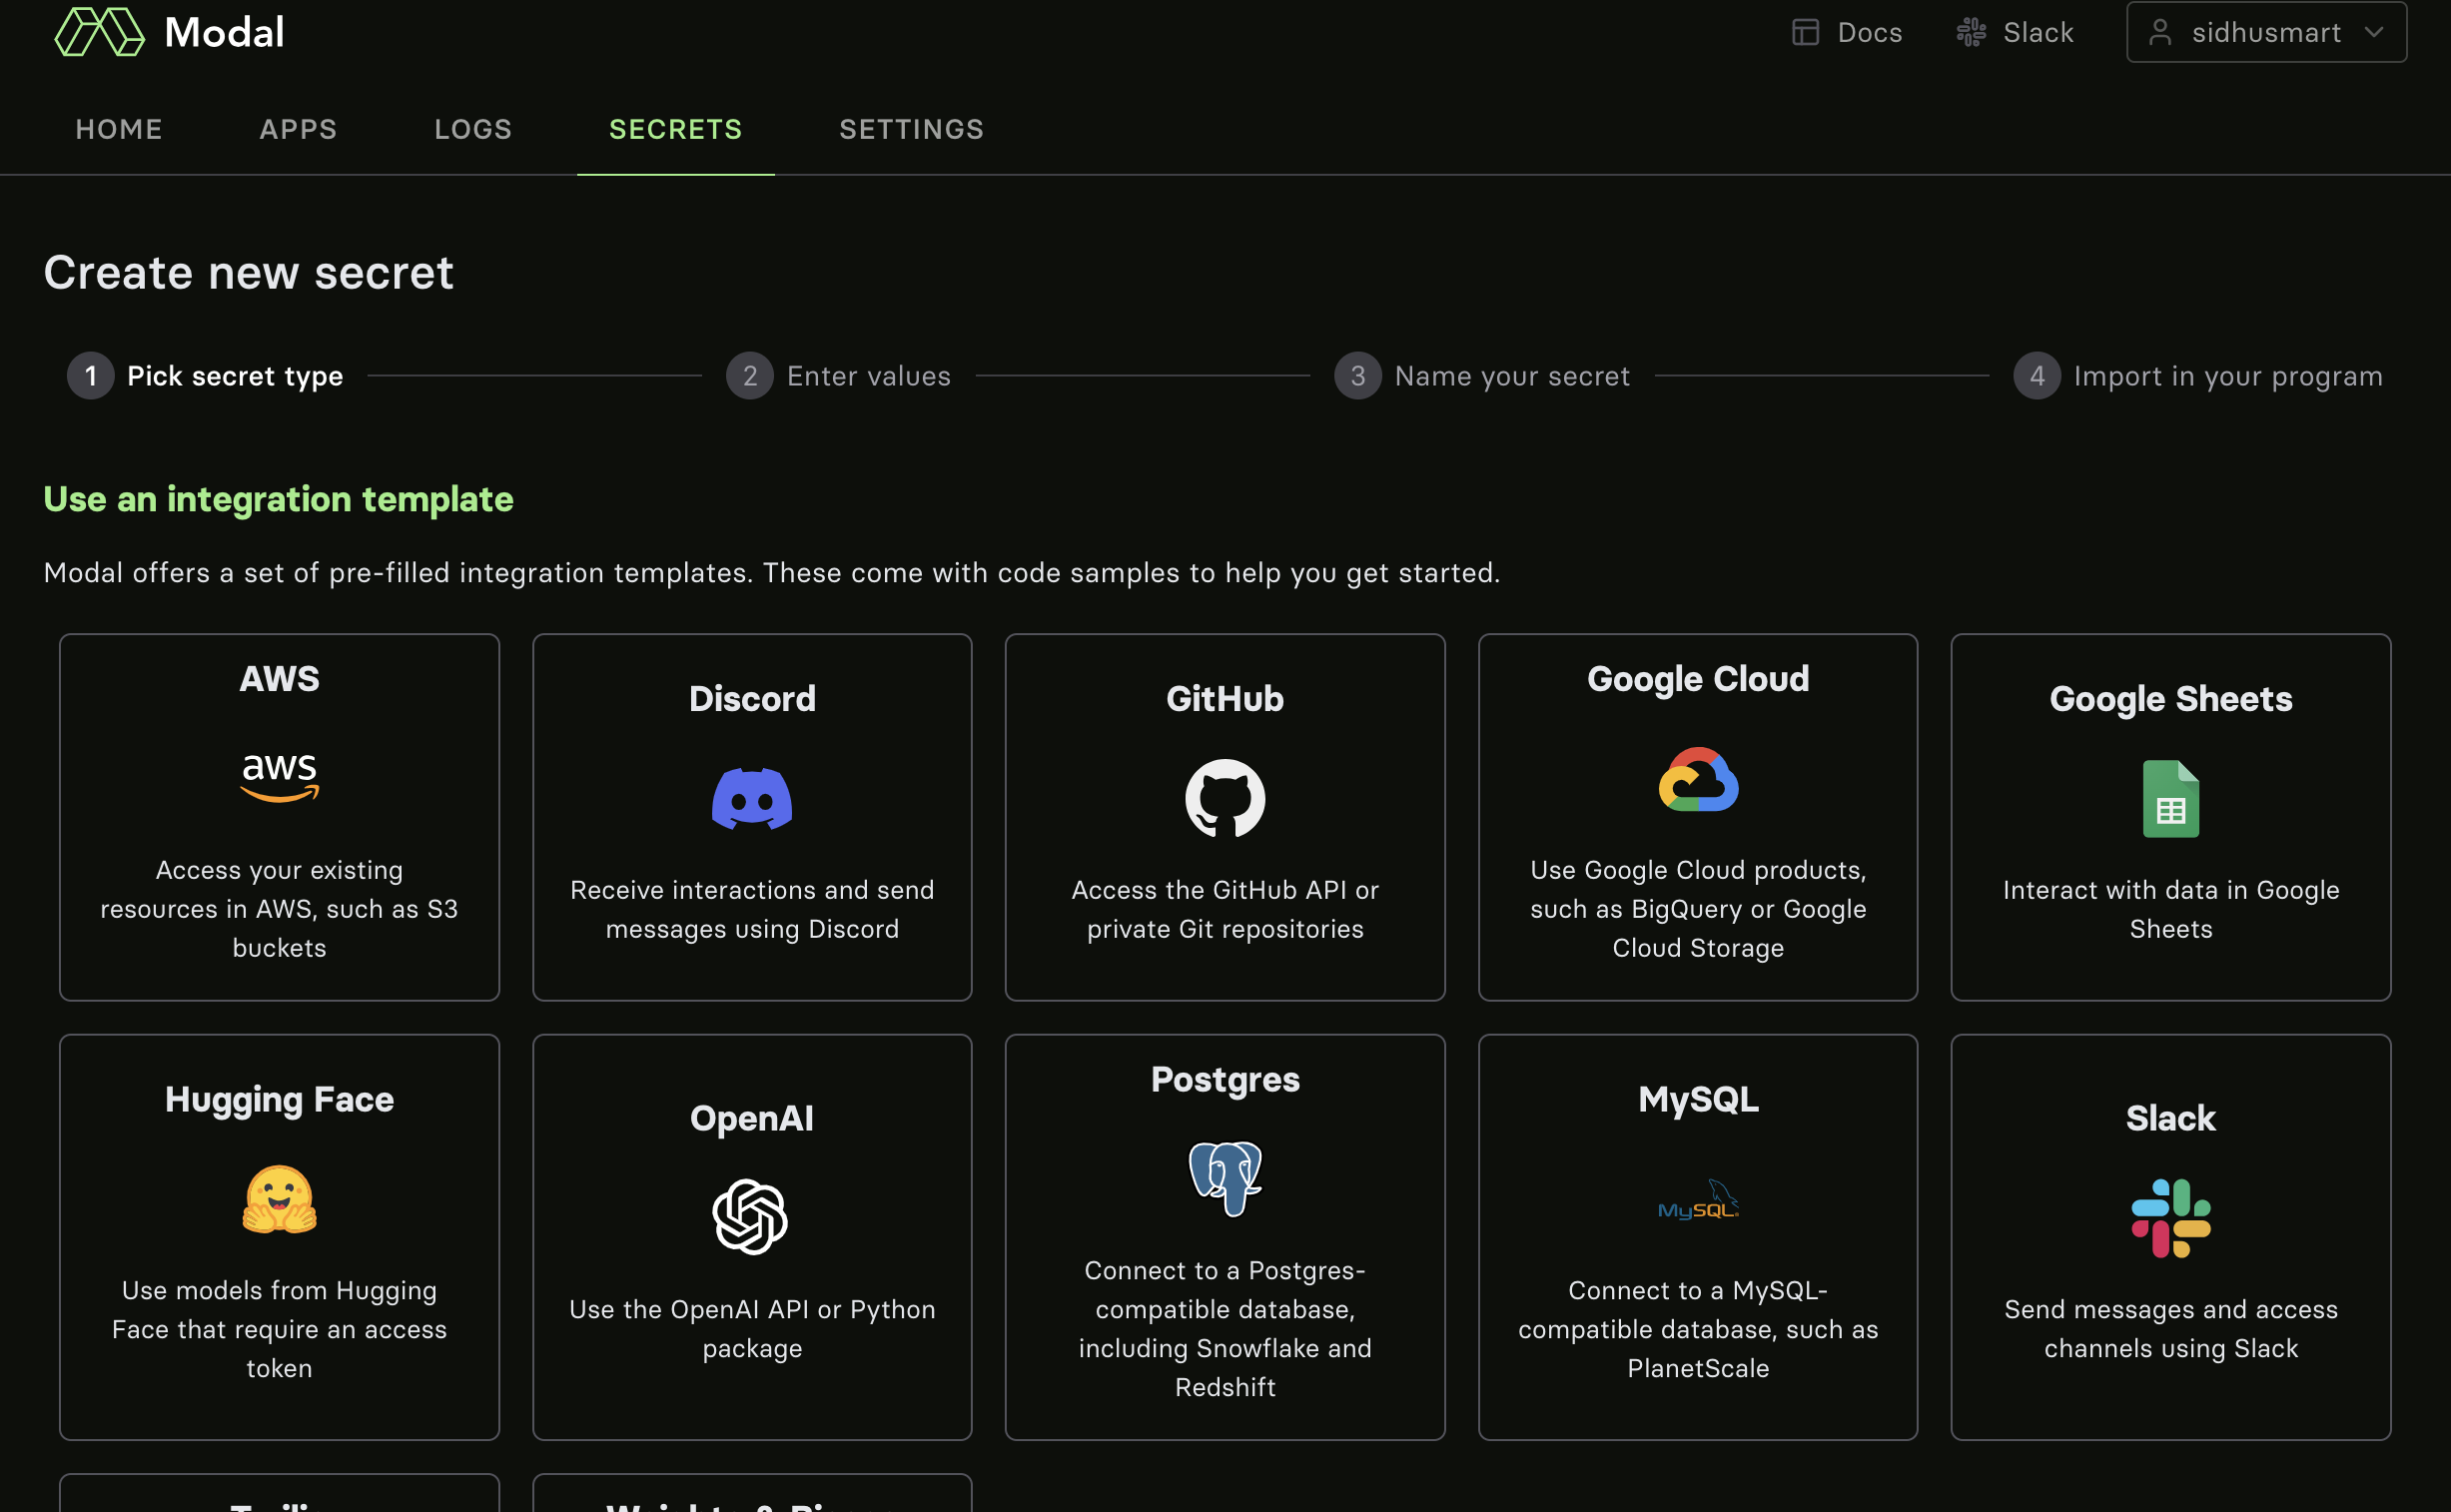

Now we are all set and let's run this integrated function with the local_entrypoint to check that our entire information extraction works.

In [ ]:
!modal run /content/podcast/podcast_backend.py --url https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49 --path /content/podcast/

If you are satisfied that everything runs as expected with the cloud function you have created then it's time to deploy and make this available. So far we have only called it by running the `modal run` command. We will now deploy the function so that it can be called by our front-end.

In [ ]:
!modal deploy /content/podcast/podcast_backend.py

As a way to test the deployed function, you can call it directly from this Colab notebook itself. If you're going to call a Modal function from within Python code then it works the same as any other local function even though it's running in the cloud. The only additional step is that we need to look it up with name of the project and function.

You can try to call the deployed functions for two or more of your favorite podcasts byt providing their feed URLs. We have provided an example below for one of my favorite podcasts - "TWIMLAI". We call the deployed modal and pass in the feed URL. We then save the output in the form of a JSON file which we can easily import to our front-end in the next step.

⚠️⚠️⚠️ ⏭ **IMPORTANT NOTE** ⏮ ⚠️⚠️⚠️

As noted in Part 1, please make sure that any podcast you choose has episodes in the 25-30 minute range. Otherwise there is a risk of the cloud function timing out; the current timeout has been set to 600 seconds to prevent long running functions and avoid cost surprises.

In [ ]:
# Trying to call the deployed function from another python session
import modal
f = modal.Function.lookup("corise-podcast-project", "process_podcast")
output = f.call('https://feeds.megaphone.fm/MLN2155636147', '/content/podcast/')

In [ ]:
import json
with open("/content/podcast/podcast-1.json", "w") as outfile:
  json.dump(output, outfile)

In the above step we have called our deployed function with an RSS feed of a podcast of our choice and saved the output. You will observe that it takes a bit of time to run this function, approximately 5 mins of runtime for a 30 min podcast. This is quite long but as the product we are building is a weekly scheduled newsletter this may not be a huge concern.

Since we are building a front-end app in the next section, we don't want to be waiting for 5 mins for the details of our podcast to load. So at this point, we would recommend that you run the previous two commands for a set of podcasts that you like and save the output json. We will pre-populate our front-end with them so that the experience is more pleasing. In our case we have chosen a podcast from The Economist, the Software Engineering Daily podcast and another podcast on AI and Machine Learning.

Please make sure to change the variable names of the podcast JSON. We choose to use podcast-1.json, podcast-2.json and so on.   

### Extension

There are multiple ways to speed-up the transcription process which is what takes the most amount of time. We provide some hints below on libraries and approaches if you want to extend your project -

- There is a super fast [implementation](https://github.com/sanchit-gandhi/whisper-jax) of Whisper using JAX which could be a drop-in replacement
- There is alternate approach of splitting up the audio into chunks by detecting silences and then parallelising it using multiple Modal GPU containers. They provide a very nice [example](https://github.com/modal-labs/modal-examples/tree/main/06_gpu_and_ml/openai_whisper/pod_transcriber) of how to achieve this

# Part 3 - Deploying the front-end application

In the final part of our AI product let's create a front-end for our podcast summarizer application. Since we want to create our product as a weekly newsletter, it's not necessary to have a front-end but this can help our users visualize what the newsletter looks like. It also gives them an opportunity to play around with their choice of RSS feeds.

Since we want to keep it simple we choose to go with a Streamlit application for our front-end. We can stick with Python as the programming language and also deploying it is easy and for free using the Streamlit Share.

## Step 1 - Use ChatGPT as your programming buddy!

In this step, we want to help you discover how one can use ChatGPT (the free web version) as a programming buddy to fulfill this task. As you will discover, it's an easy way to get started with boilerplate code and also request customizations as we go along.

The instructor will go through the steps on how to use ChatGPT and what to be careful about when doing so in the Project kick-off session. In the end we hope to create a functioning Streamlit app.

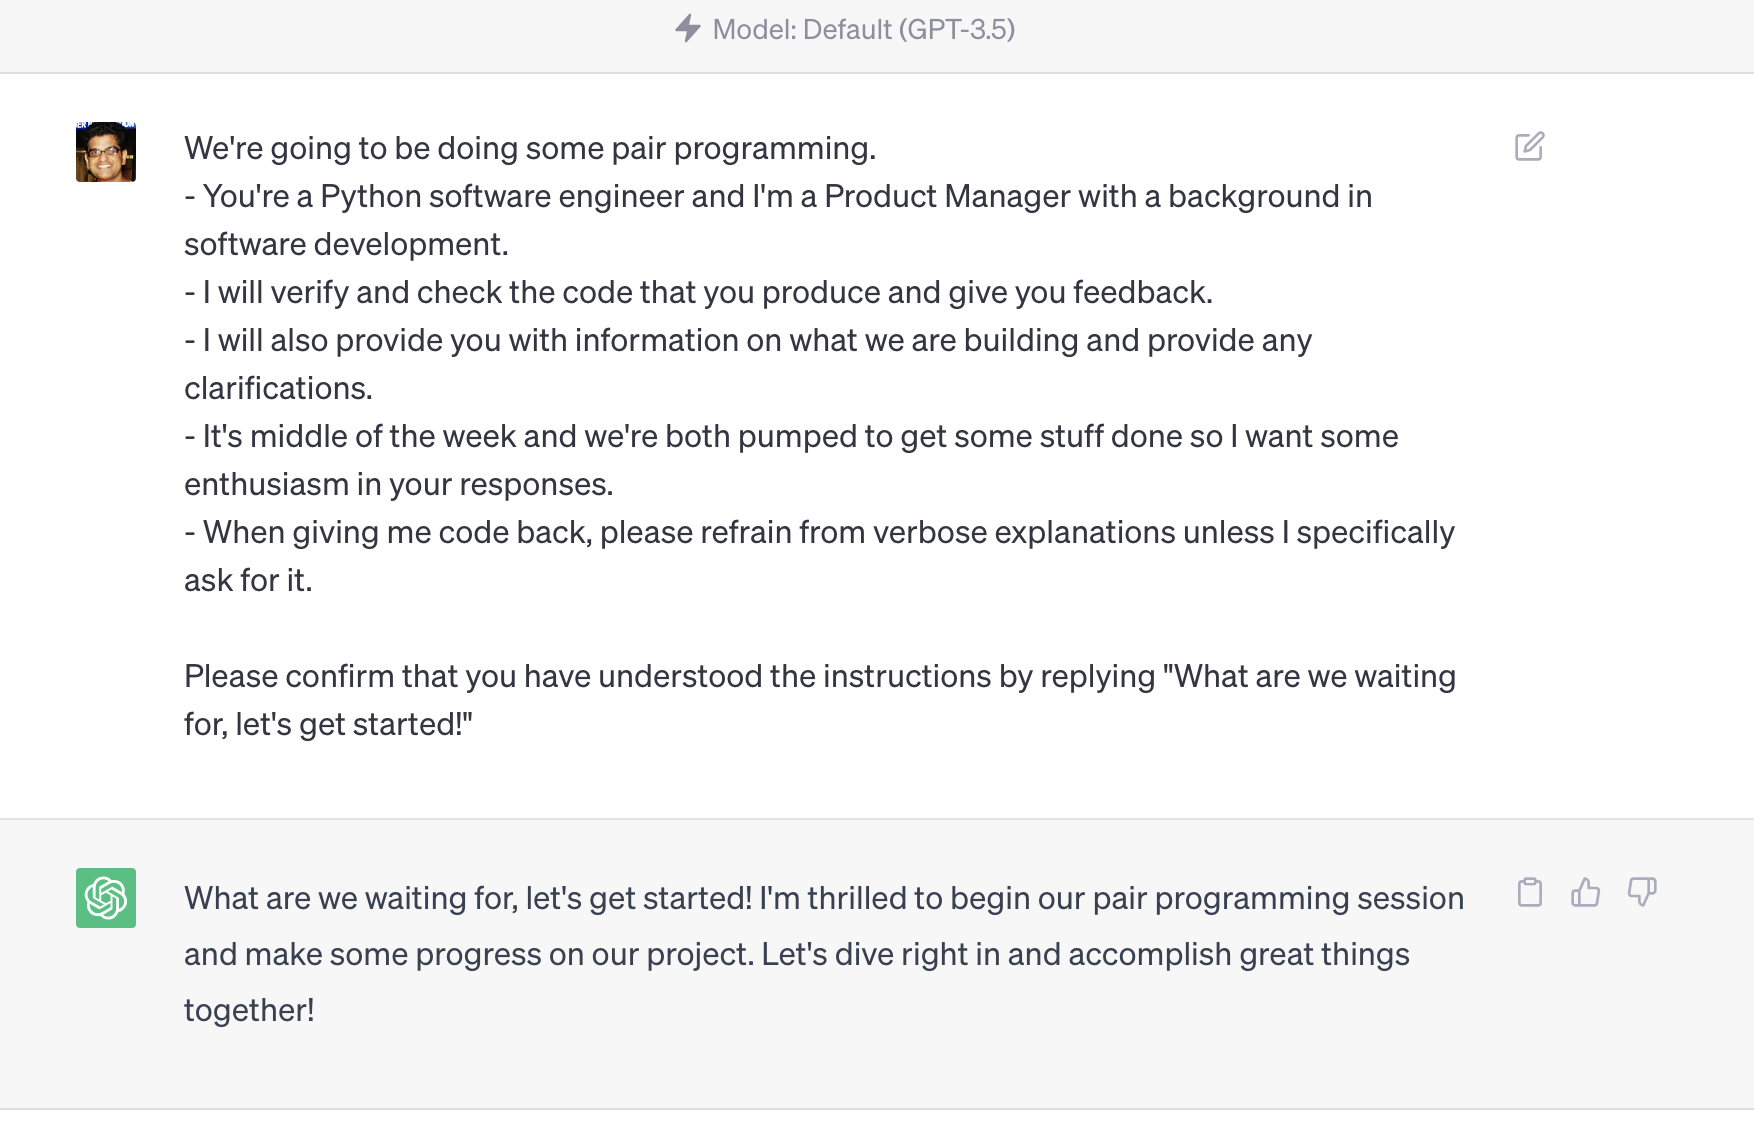

## Step 2 - Deploy the Streamlit to the cloud

We hope that you enjoyed the pair programming exercise with ChatGPT. Hopefully it went well and you have a final version of the Streamlit app that you want to host. Regardless, we have provided a simple example of this app in the code below. You can follow the instructions here to host the app.

In [ ]:
%%writefile /content/podcast/podcast_frontend.py
import streamlit as st
import modal
import json
import os

def main():
    st.title("Newsletter Dashboard")

    available_podcast_info = create_dict_from_json_files('.')

    # Left section - Input fields
    st.sidebar.header("Podcast RSS Feeds")

    # Dropdown box
    st.sidebar.subheader("Available Podcasts Feeds")
    selected_podcast = st.sidebar.selectbox("Select Podcast", options=available_podcast_info.keys())

    if selected_podcast:

        podcast_info = available_podcast_info[selected_podcast]

        # Right section - Newsletter content
        st.header("Newsletter Content")

        # Display the podcast title
        st.subheader("Episode Title")
        st.write(podcast_info['podcast_details']['episode_title'])

        # Display the podcast summary and the cover image in a side-by-side layout
        col1, col2 = st.columns([7, 3])

        with col1:
            # Display the podcast episode summary
            st.subheader("Podcast Episode Summary")
            st.write(podcast_info['podcast_summary'])

        with col2:
            st.image(podcast_info['podcast_details']['episode_image'], caption="Podcast Cover", width=300, use_column_width=True)

        # Display the podcast guest and their details in a side-by-side layout
        col3, col4 = st.columns([3, 7])

        with col3:
            st.subheader("Podcast Guest")
            st.write(podcast_info['podcast_guest']['name'])

        with col4:
            st.subheader("Podcast Guest Details")
            st.write(podcast_info["podcast_guest"]['summary'])

        # Display the five key moments
        st.subheader("Key Moments")
        key_moments = podcast_info['podcast_highlights']
        for moment in key_moments.split('\n'):
            st.markdown(
                f"<p style='margin-bottom: 5px;'>{moment}</p>", unsafe_allow_html=True)

    # User Input box
    st.sidebar.subheader("Add and Process New Podcast Feed")
    url = st.sidebar.text_input("Link to RSS Feed")

    process_button = st.sidebar.button("Process Podcast Feed")
    st.sidebar.markdown("**Note**: Podcast processing can take upto 5 mins, please be patient.")

    if process_button:

        # Call the function to process the URLs and retrieve podcast guest information
        podcast_info = process_podcast_info(url)

        # Right section - Newsletter content
        st.header("Newsletter Content")

        # Display the podcast title
        st.subheader("Episode Title")
        st.write(podcast_info['podcast_details']['episode_title'])

        # Display the podcast summary and the cover image in a side-by-side layout
        col1, col2 = st.columns([7, 3])

        with col1:
            # Display the podcast episode summary
            st.subheader("Podcast Episode Summary")
            st.write(podcast_info['podcast_summary'])

        with col2:
            st.image(podcast_info['podcast_details']['episode_image'], caption="Podcast Cover", width=300, use_column_width=True)

        # Display the podcast guest and their details in a side-by-side layout
        col3, col4 = st.columns([3, 7])

        with col3:
            st.subheader("Podcast Guest")
            st.write(podcast_info['podcast_guest']['name'])

        with col4:
            st.subheader("Podcast Guest Details")
            st.write(podcast_info["podcast_guest"]['summary'])

        # Display the five key moments
        st.subheader("Key Moments")
        key_moments = podcast_info['podcast_highlights']
        for moment in key_moments.split('\n'):
            st.markdown(
                f"<p style='margin-bottom: 5px;'>{moment}</p>", unsafe_allow_html=True)

def create_dict_from_json_files(folder_path):
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    data_dict = {}

    for file_name in json_files:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            podcast_info = json.load(file)
            podcast_name = podcast_info['podcast_details']['podcast_title']
            # Process the file data as needed
            data_dict[podcast_name] = podcast_info

    return data_dict

def process_podcast_info(url):
    f = modal.Function.lookup("corise-podcast-project", "process_podcast")
    output = f.call(url, '/content/podcast/')
    return output

if __name__ == '__main__':
    main()

The previous step would have written a python file containing all the code for our Streamlit front-end. The next step is to download this locally by executing the following cell.

In [ ]:
from google.colab import files

# Download the file locally
files.download('/content/podcast/podcast_frontend.py')

In a similar way, we also create the `requirements.txt` which contains only two dependencies - modal and streamlit. And same as before, we download this file locally.

In [ ]:
%%writefile /content/podcast/requirements.txt
streamlit
modal

In [ ]:
from google.colab import files

# Download the file locally
files.download('/content/podcast/requirements.txt')

Finally, we want to pre-populate the streamlit app with some pre-processed podcasts. You should have already done this in the previous section and saved the output JSON files. Please download them by executing the below cell. Please remember to change the names of the files based on what you chose in the previous section. We chose to go with the name - podcast-1, podcast-2 and so on.

In [ ]:
from google.colab import files

# Download the file locally
files.download('/content/podcast/podcast-1.json')
files.download('/content/podcast/podcast-2.json')
files.download('/content/podcast/podcast-3.json')

### Upload files to a Github repo

Please verify that you've downloaded the following files:

- `podcast_frontend.py`
- `requirements.txt`
- `podcast-1.json`
- `podcast-2.json`
- `podcast-3.json`

In order to create a Streamlit app on the cloud we need to have our app files in a github repo. The Streamlit cloud app pulls the code directly from the github repo. What's great is that once it is deployed, any check-ins and changes you make to the files in the repo are automatically reflected in the app!

First, please create an account in [GitHub](https://github.com/signup) if you don't already have one.

Next, once you are logged in, click on the **New** option to create a new repo where we will upload the code for the front-end app.

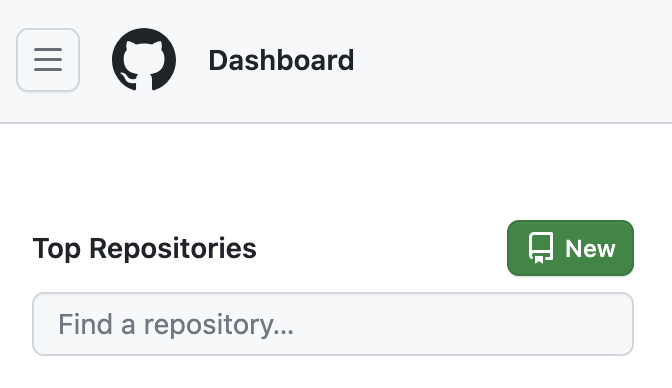



Here you can provide the following information:
- **Repository name**: you can pick the name of your product
- **License**: you can choose any license
- **Public or private?** you need to have a public repo in order for Streamlit Share to pull the code

Then upload the files that you downloaded previously to this URL below. ***Please modify it before copy-pasting it***:

```https://github.com/[YOUR_ACCOUNT_NAME]/[YOUR_REPOSITORY_NAME]/upload/main```

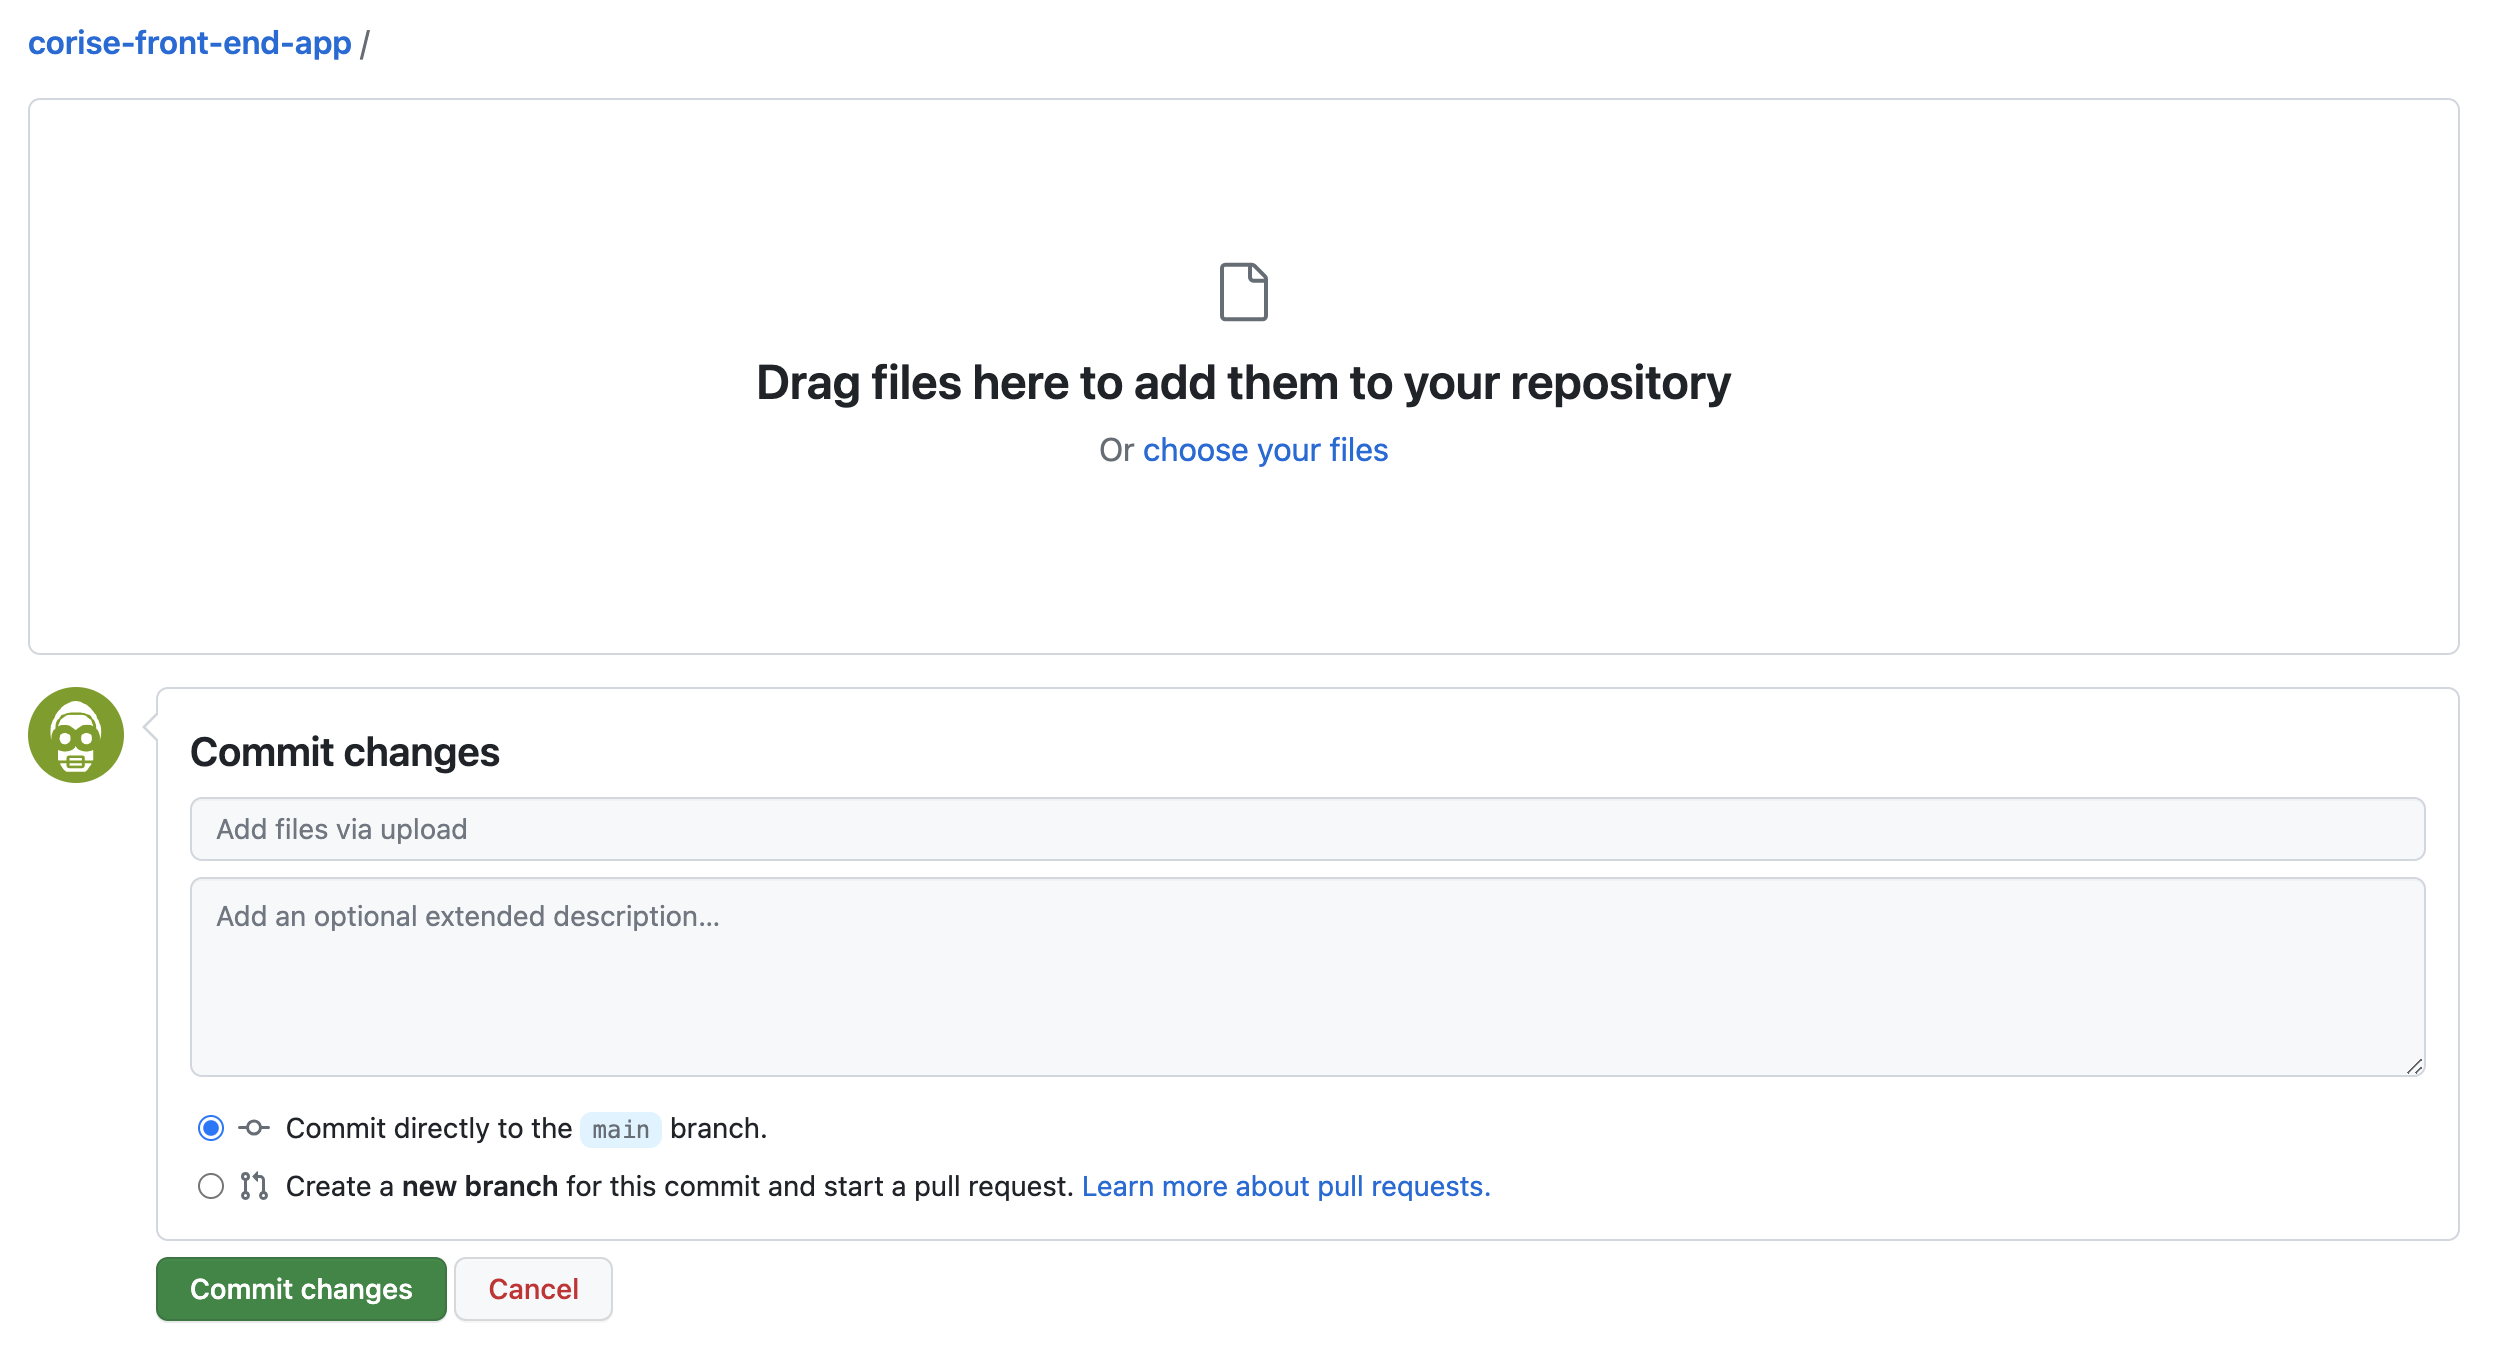

### Create a Streamlit Share App

We have uploaded files to our repo and now it's time to initialize the Streamlit app. First, you have to create an account on [Streamlit Share](https://share.streamlit.io/signup).

We would recommend continuing with your Github account that you created in the previous step. This allows Streamlit to easily pull the code for the app.

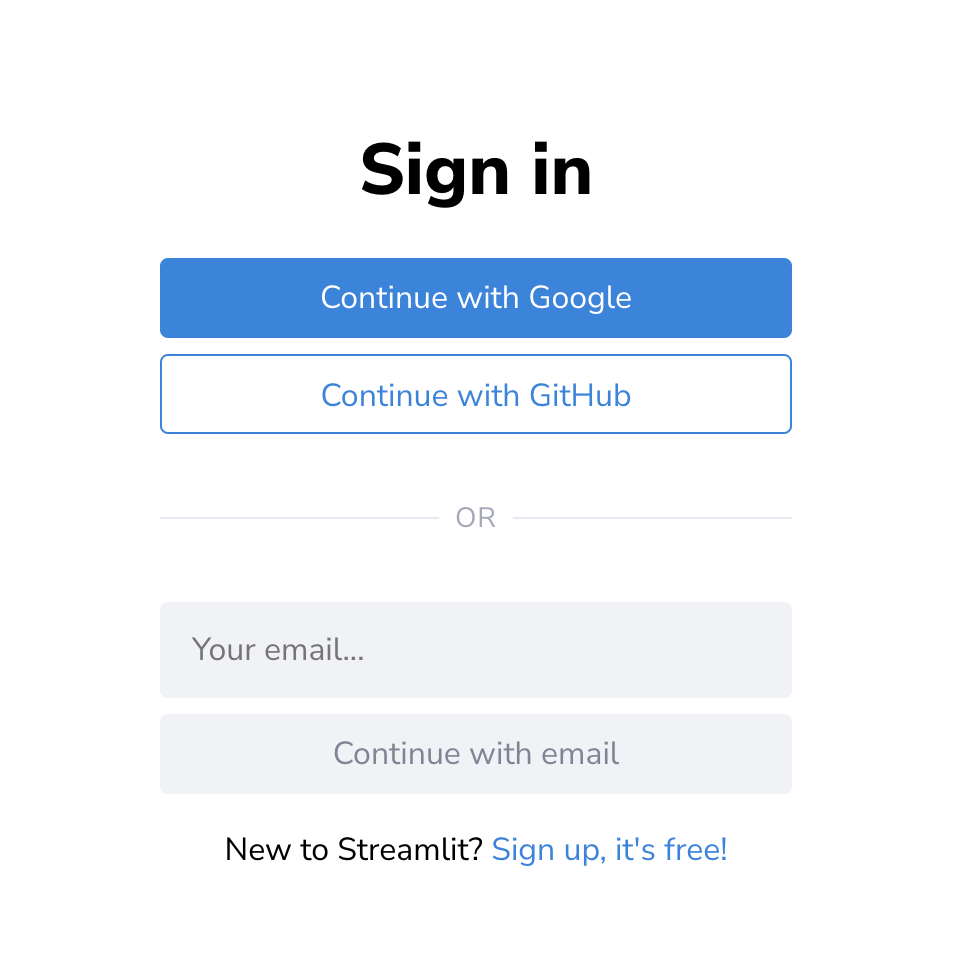

Then, select **New app** **>** **Deploy a new app...** **>** **From existing repo**.

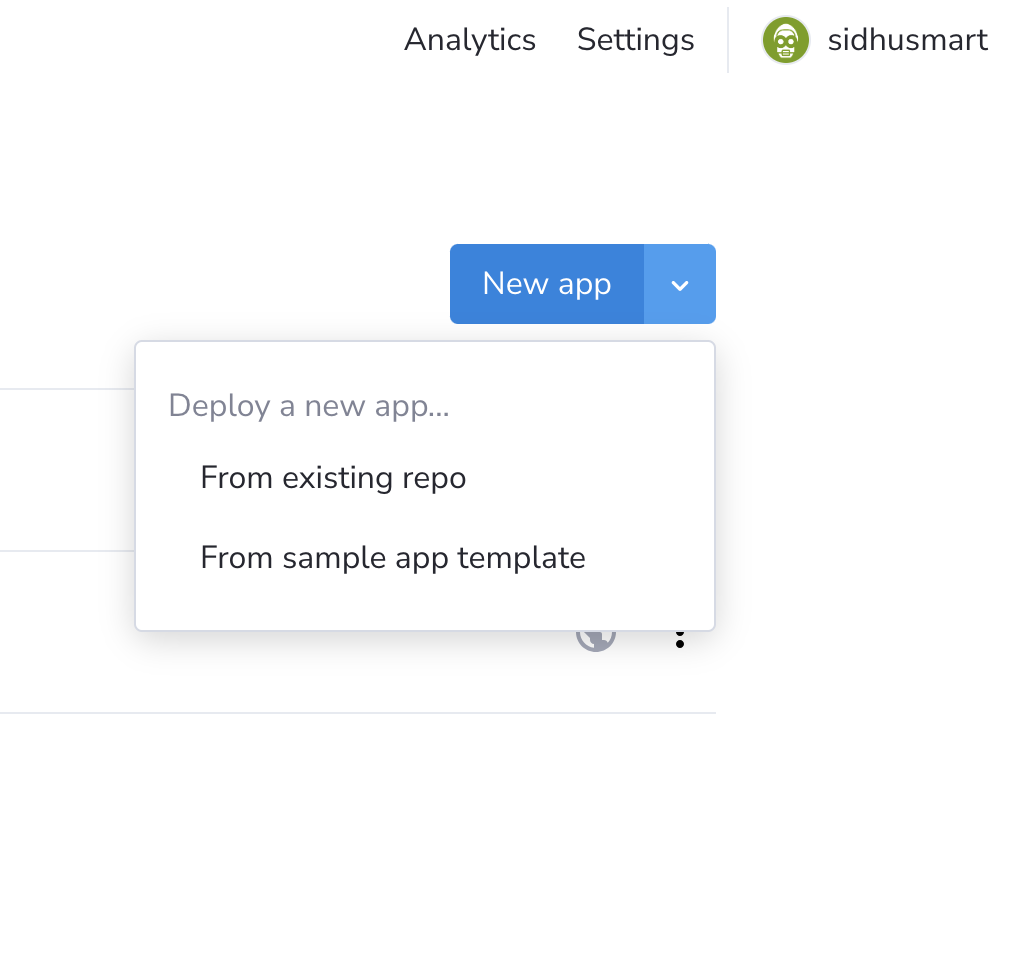

Use the same repository that you created previously by providing your:

```[GITHUB_ACCOUNT_NAME]/[GITHUB_REPOSITORY]```

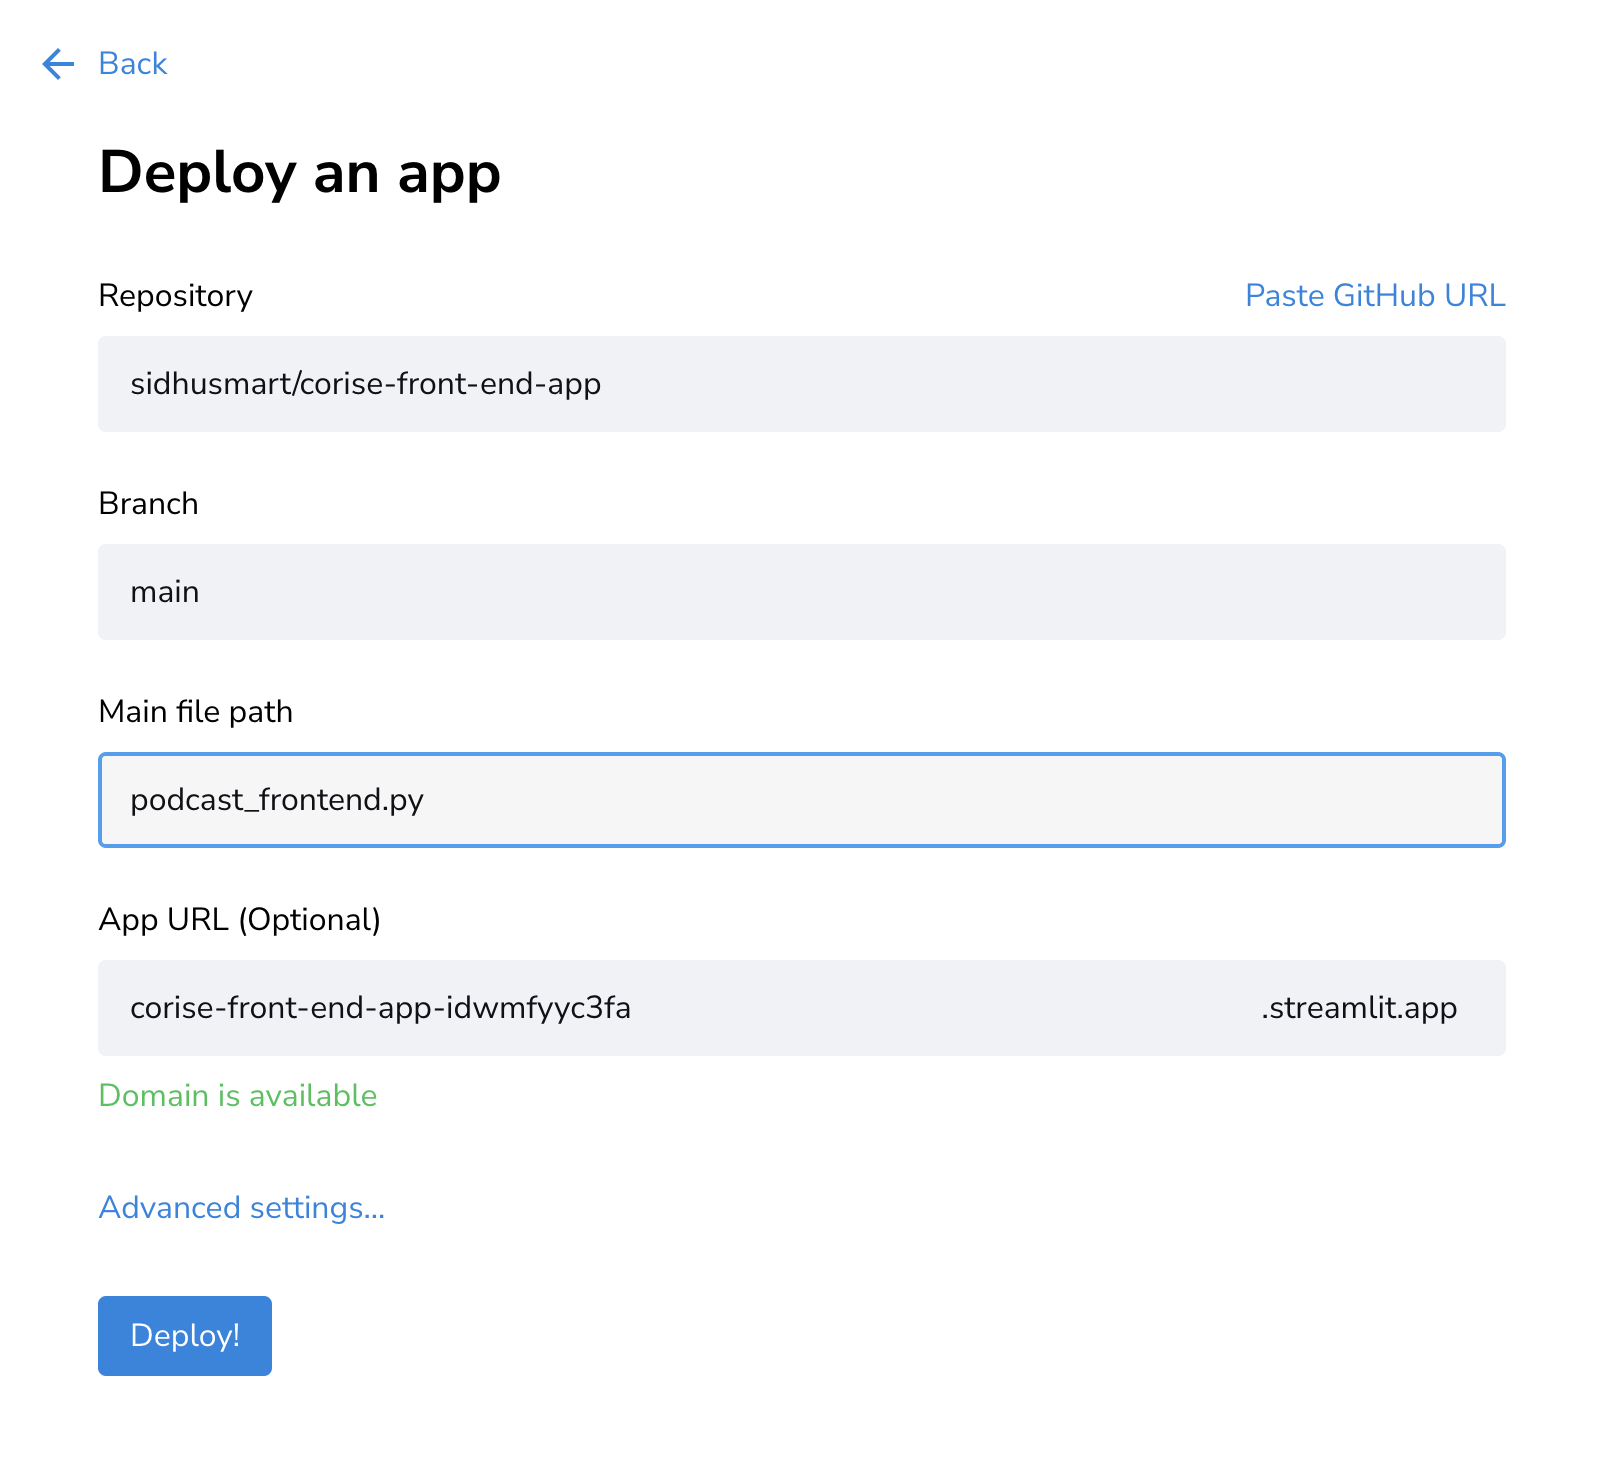

### Adding Modal secrets

Since we are going to call the cloud-deployed function directly from the app we also need to authenticate ourselves with Modal. For this we need to add the MODAL_TOKEN_ID and MODAL_TOKEN_SECRET to the secrets part of the Streamlit app.

To do this, please click on `Advanced settings` and then paste in your Token and Secrets as shown in the screenshot.

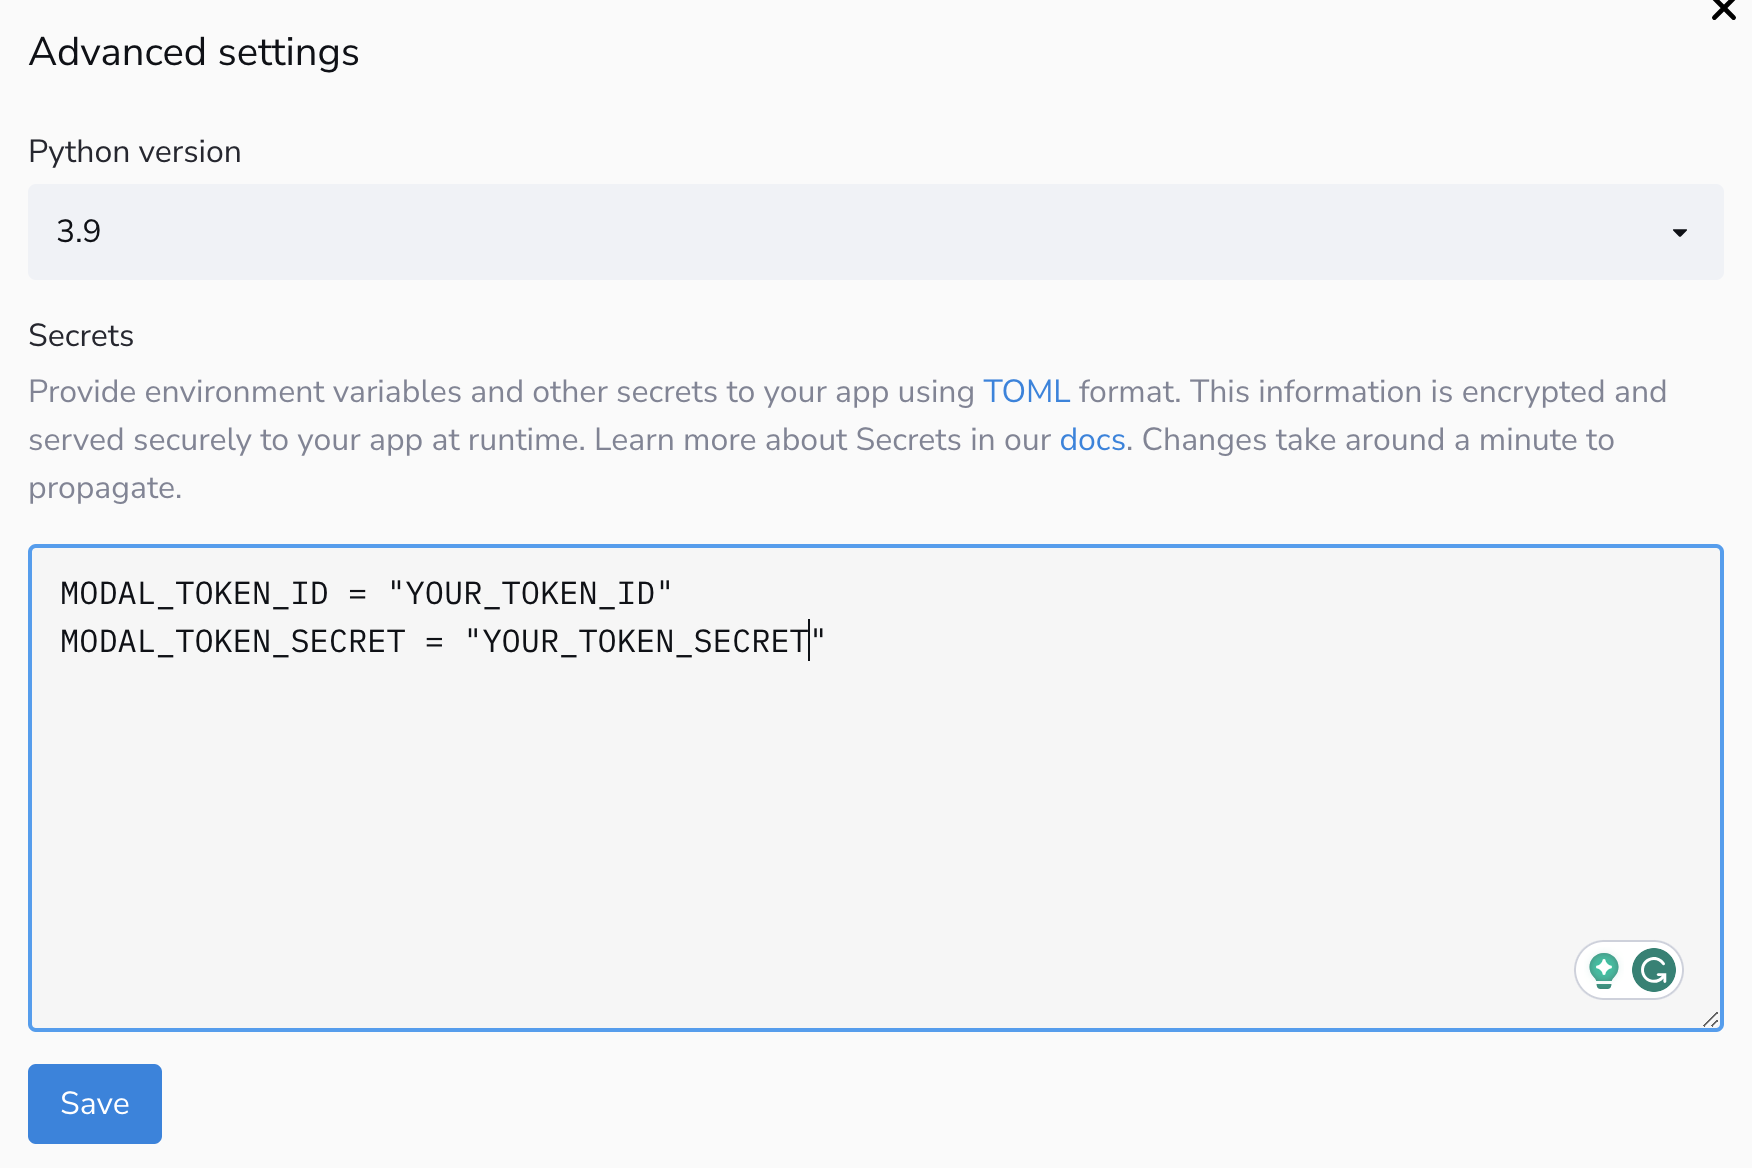

This ensures that we will be able to call the function that we have deployed previously.

Once you choose to deploy it will take a few minutes before the app is accesible. It will be generated at the same URL shown on the setup screen and would like something as below.

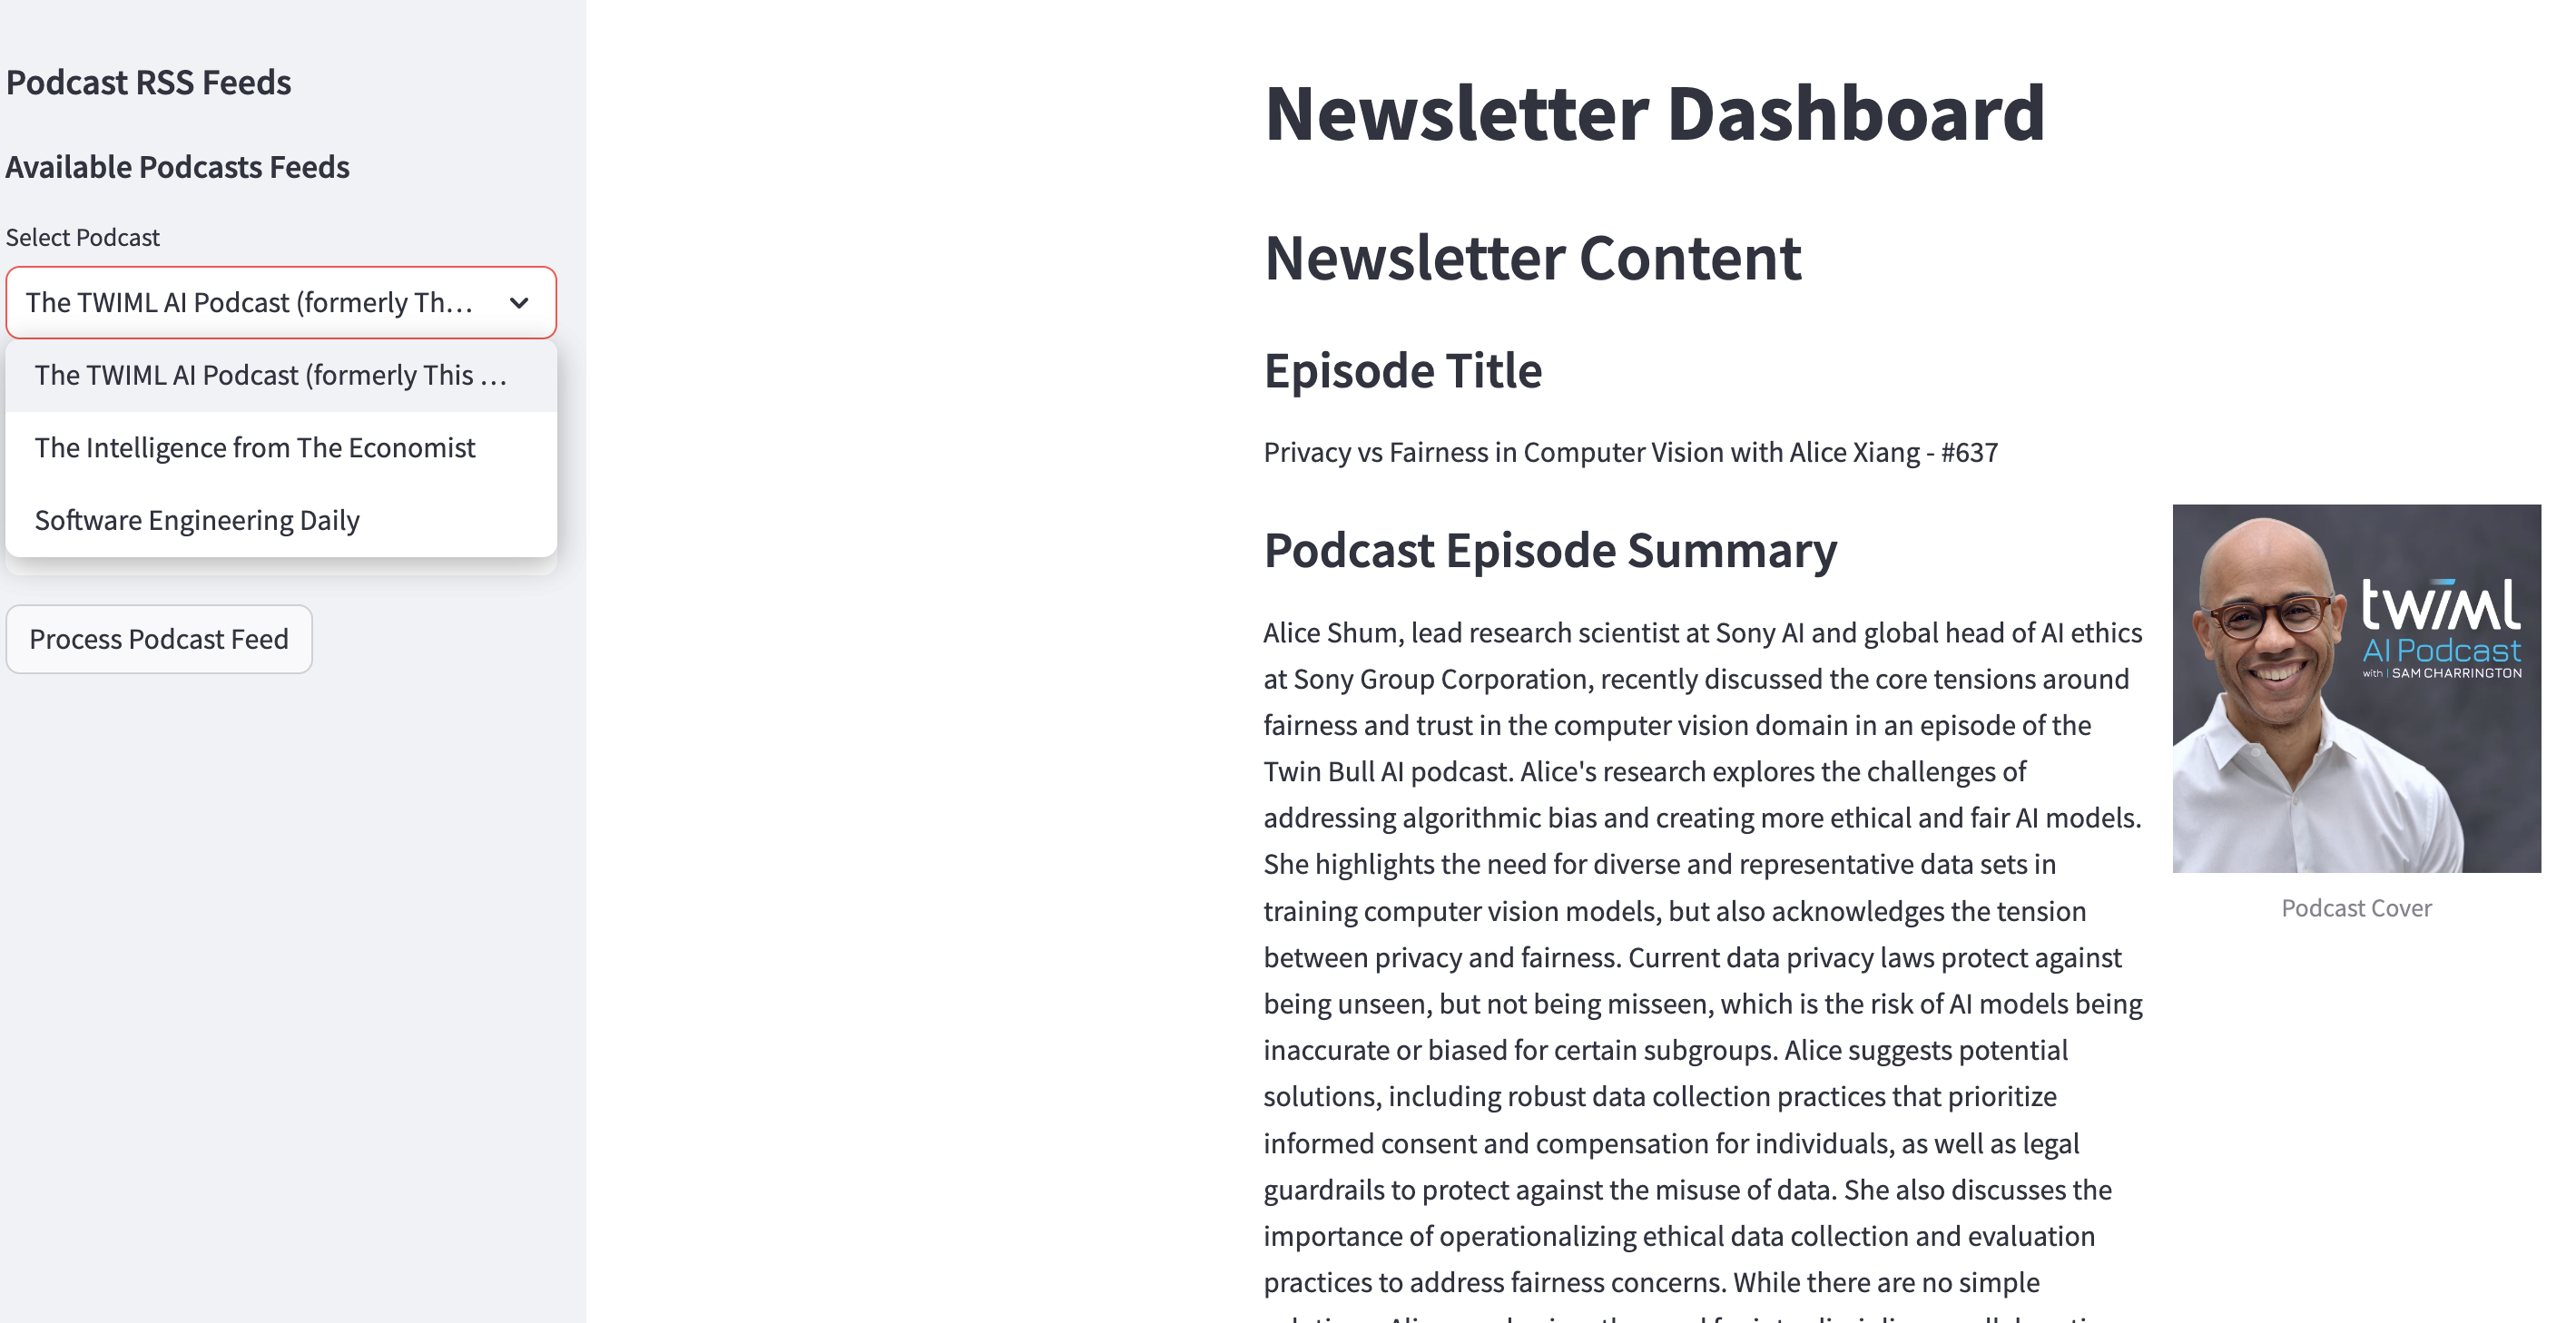